In [3]:
from __future__ import print_function
from IPython.display import display, clear_output
from datetime import datetime, timedelta
from itertools import product
from pandas.plotting import register_matplotlib_converters

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf


pd.options.display.max_columns = None
register_matplotlib_converters()


%matplotlib inline

/code/venvs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/code/venvs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/code/venvs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/code/venvs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarnin

## H3 Coordinates

In [ ]:
%pip install h3

# May need to restart kernel if installed for the first time
from h3 import h3

bounding_box = ([30.727818,104.043333],[30.726490,104.129076],[30.655191,104.129591],[30.652828,104.042102])
for lat, lng in bounding_box:
    h3_address = h3.geo_to_h3(lat, lng, 8)
    hex_center_coordinates = h3.h3_to_geo(h3_address) # array of [lat, lng]
    hex_boundary = h3.h3_to_geo_boundary(h3_address) # array of arrays of [lat, lng]

In [ ]:
bounding_box = ([30.727818,104.043333],[30.726490,104.129076],[30.655191,104.129591],[30.652828,104.042102])

## Given Hex Coordinates

In [43]:
import csv

coords = []
polygon = dict()
ids = []

lats = 0
with open('data/hexagon_grid_table.csv', 'r') as csvfile:
    for row in csv.reader(csvfile):
        if len(row) != 13:
            continue
        ids.append(row[0])        
        lng = sum([float(row[i]) for i in range(1, 13, 2)]) / 6
        lat = sum([float(row[i]) for i in range(2, 13, 2)]) / 6
        coords.append((lat, lng))
        polygon[row[0]] = (list(zip([float(row[i]) for i in range(2, 13, 2)], 
                                    [float(row[i]) for i in range(1, 13, 2)])))


In [ ]:
from scipy.spatial import KDTree


tree = KDTree(coords)
_, i = tree.query((30.71, 104.50))
print('5973d1e3fdf1f878', ids[i])
_, i = tree.query((30.40, 103.99))
print('27471aff3df268a1', ids[i])
_, i = tree.query((30.37, 104.52))
print('15948343c6223064', ids[i])


_, i = tree.query((30.655191,104.129591))
print(ids[i], coords[i])
_, i = tree.query((30.727818,104.043333))
print(ids[i], coords[i])
_, i = tree.query((30.726490,104.129076))
print(ids[i], coords[i])

## Cancellation Probability

In [6]:
import csv


cancel_rates = [0] * 10
total_rows = 0
for date in range(1,31):
    with open(f'data/total_order_cancellation_probability/order_201611{date:02d}_cancel_prob', 'r') as csvfile:
        for row in csv.reader(csvfile):
            assert len(row) == 11
            for i in range(1, len(row)):
                cancel_rates[i - 1] += float(row[i])
            total_rows += 1

y = [r / total_rows for r in cancel_rates]            
y          

[0.03493870431607338,
 0.03866776293519174,
 0.041760728528424544,
 0.05007157148698522,
 0.059208628863229744,
 0.07455933064560377,
 0.08571890195014424,
 0.09848048263719175,
 0.11230701971967454,
 0.12717324794320947]

fit [ 5.04970371e-02  6.39626539e-04 -3.83965901e+02 -1.30398096e-02]


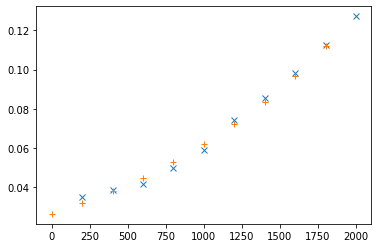

In [7]:
import scipy
import itertools

x = list(range(200, 2001, 200))
y = [r / total_rows for r in cancel_rates]
fit, _ = scipy.optimize.curve_fit(lambda t,a,b,c,d: a*np.exp(b*(t+c))+d,  x,  y,  p0=(0.1, 0.01, 0, -0.02))
print('fit', fit)
plt.plot(x, y, 'x')
#print(func(200, fit[0], fit[1]))
x_extended = list(range(0, 2000, 200))
plt.plot(x_extended, [fit[0] * np.exp(fit[1] * (a + fit[2])) + fit[3] for a in x_extended], '+')
         

## Time

In [ ]:
import time

time.gmtime(148865000).tm_hour

## Online Search Hyperparameters

In [ ]:
import random

# dql: {true, false}
dql = random.random() < 0.5
# alpha: [0.0001, 0.1] (log)
alpha = 10 ** -(3 * random.random() + 1)
# gamma: [0.99, 0.99999] (log)
gamma = 1 - 10 ** -(3 * random.random() + 2)
# idle reward: [-1e-2, 0] (log)
penalize_idle = random.random() < 0.5
idle_reward = -1e-2 * random.random() if penalize_idle else 0
# open_request_reward: [0, 0.1] (log)
open_request_reward = 10 ** (random.random() - 2)

# Random hyperparameter search
f'd={dql}, a={alpha:.4f}, g={gamma:.6f}, ir={idle_reward:.3f}, orr={open_request_reward:.2f}'

In [ ]:
# Default
f'd=False, a=2/(5*60), g=0.9999, ir=-2/(60*60), orr=-2/(60*60)'

## Offline Search (orders)

In [2]:
import sys

sys.path.append("model")

import model.grid


if 'grid' not in locals():
    grid = model.grid.Grid()
if 'grid_cache' not in locals():
    grid_cache = dict()
if 'dither_cache' not in locals():
    dither_cache = dict()


def cached_lookup(lng, lat):
    if (lng, lat) in grid_cache:
        return grid_cache[(lng, lat)]
    grid_id = grid.lookup(lng, lat)
    grid_cache[(lng, lat)] = grid_id
    return grid_id

In [5]:
import collections
import time


def _get_state(grid_id: str, t: float):
    t = time.gmtime(t)
    return grid_id  #, 24 * t.tm_wday + t.tm_hour


def state_value(grid_id: str, t: float, state_values) -> float:
    # TODO: time/space kernel
    u = (t % 3600) / 3600
    #print(f'{time.asctime(time.gmtime(t))}: {(1 - u)} * {_get_state(grid_id, t)} + {u} * {_get_state(grid_id, t + 3600)}')
    return (1 - u) * state_values[_get_state(grid_id, t)] + \
        u * state_values[_get_state(grid_id, t + 3600)]


def update_state_value(grid_id: str, t: float, delta: float, state_values, counts) -> None:
    # TODO: time/space kernel
    u = (t % 3600) / 3600
    state_values[_get_state(grid_id, t)] += (1 - u) * delta
    state_values[_get_state(grid_id, t + 3600)] += u * delta
    

In [6]:
import collections
import csv
import math


def fetch_examples():
    dates, start_grids, start_times, end_grids, end_times, rewards = [], [], [], [], [], []
    for date in range(1, 31):
        with open(f'data/total_ride_request/order_201611{date:02d}', 'r') as csvfile:
            for row in csv.reader(csvfile):
                dates.append(date)
                order_id, start_sec, end_sec, start_lng, start_lat, end_lng, end_lat, reward = row
                start_times.append(float(start_sec))
                end_times.append(float(end_sec))
                rewards.append(float(reward))
                start_grid = cached_lookup(float(start_lng), float(start_lat))                    
                end_grid = cached_lookup(float(end_lng), float(end_lat))
                start_grids.append(start_grid)
                end_grids.append(end_grid)
    data = {
        'date': dates,
        'start_grid': start_grids,
        'start_time': start_times,
        'end_grid':  end_grids,
        'end_time': end_times,
        'reward': rewards,        
    }
    return pd.DataFrame(data)


def hp_search(alpha, gamma, examples, state_values=None, counts=None, eval_start_date=24):
    if state_values is None:
        state_values = collections.defaultdict(float)
        counts = collections.defaultdict(float)
        
    updates = []
    for i, row in examples.iterrows():
        s0 = state_values[row.start_grid]
        s1 = state_values[row.end_grid]
                
        # One-step TD Error (this is Learnable, unlike Bellman Error or Value Error)
        update = (row.reward + gamma * s1 - s0)
        state_values[row.start_grid] = s0 + alpha * update
        #update_state_value[row.start_grid, row.start_time, alpha * update, state_values)
                
        if row.date >= eval_start_date:
            updates.append(update)
    return state_values, pd.Series(updates)

In [7]:
examples = fetch_examples()
print(examples.start_grid.unique().shape)
examples.describe()

(2458,)


,date,start_time,end_time,reward
count,7.065937e+06,7.065937e+06,7.065937e+06,7.065937e+06
mean,1.581136e+01,1.479261e+09,1.479263e+09,4.224453e+00
std,8.618927e+00,7.447905e+05,7.447896e+05,2.854039e+00
min,1.000000e+00,1.477930e+09,1.477930e+09,1.000000e-02
25%,8.000000e+00,1.478612e+09,1.478613e+09,2.190000e+00
50%,1.600000e+01,1.479279e+09,1.479280e+09,3.410000e+00
75%,2.300000e+01,1.479903e+09,1.479904e+09,5.180000e+00
max,3.000000e+01,1.480522e+09,1.480582e+09,1.074600e+02


In [6]:
alpha = 10/(5*60)
gamma = 0.9
state_values, updates = hp_search(alpha, gamma, examples)
print(f'{alpha:.6f}, {gamma:.6f}: {updates.mean()}, {updates.std()}, {np.power(updates, 2).mean()}')
print(len(state_values))

0.033333, 0.900000: 0.0769331667887762, 3.760957583882774, 14.150712474732426
3404


In [8]:
state_values = collections.defaultdict(float)
results = []
for _ in range(100):
    alpha = 0.4 * random.random()
    gamma = 0.9  # Larger values always have higher absolute error
    state_values, updates = hp_search(alpha, gamma, examples)
    print(f'{alpha:.6f}, {gamma:.6f}: {updates.mean()}, {updates.std()}, {np.power(updates, 2).mean()}')
    results.append([alpha, gamma, updates.mean(), updates.std(), np.power(updates, 2).mean()])

0.247138, 0.900000: 0.014700675819376877, 4.049081828850633, 16.39527027925193
0.328591, 0.900000: 0.011533344545831232, 4.251275242950836, 18.07346375084675
0.276340, 0.900000: 0.013371481023723972, 4.11780121874731, 16.95645586151205
0.089446, 0.900000: 0.034270731087465284, 3.7551106302801416, 14.102022168897454
0.323559, 0.900000: 0.011686911505330053, 4.237802816876659, 17.95909890629363
0.016518, 0.900000: 0.1415514245093175, 3.887451427318619, 15.132306660506547
0.004539, 0.900000: 0.4600728529161816, 4.499384851638774, 20.456119358264992
0.160528, 0.900000: 0.021128654042381425, 3.868777953598702, 14.9678806130496
0.309930, 0.900000: 0.012125416745002194, 4.201991275187454, 17.65686748504674
0.194976, 0.900000: 0.01795346330311523, 3.9362169736826482, 15.494117424938654
0.113260, 0.900000: 0.02822887719912342, 3.7877591666092805, 14.347908071480225
0.173030, 0.900000: 0.019844250689444544, 3.8925586810752693, 15.152398111871026
0.192145, 0.900000: 0.018175365819868797, 3.930453

KeyboardInterrupt: 

In [ ]:
sorted_results = pd.DataFrame(results, columns=['alpha', 'gamma', 'update_mean', 'update_std', 'mse']).\
    sort_values('mse')
display(sorted_results.head())

In [ ]:
if sorted_results is not None:
    alpha, gamma = sorted_results.iloc[0].alpha, sorted_results.iloc[0].gamma
    print(alpha, gamma)
    best, best_counts, best_err = dict(state_values), collections.defaultdict(), float('inf')
    for t in range(100):
        state_values, updates = hp_search(alpha, gamma, 
                                          examples,
                                          state_values=dict(best))
        print(examples.shape, len(state_values), len(best))
        print(f'{alpha:.6f}, {gamma:.6f}: {updates.mean()}, {updates.std()}, {np.power(updates, 2).mean()}')
        err = np.power(updates, 2).mean()
        if err < best_err:
            best, best_err = dict(state_values), err
            
    print(len(best))
    with open(f'model/init_values.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for grid_id, value in best.items():
            writer.writerow([grid_id, value])

In [ ]:
print('Done.')

## Offline Search (No Alpha)

In [19]:
def hp_search_mean(gamma, examples, state_values=None, counts=None, eval_start_date=24):
    if state_values is None:
        state_values = collections.defaultdict(float)
        counts = collections.defaultdict(float)
        
    updates = []
    for i, row in examples.iterrows():
        s0 = state_values[row.start_grid]
        s1 = state_values[row.end_grid]
                
        # One-step TD Error (this is Learnable, unlike Bellman Error or Value Error)
        update = (row.reward + gamma * s1 - s0)
        counts[row.start_grid] += 1
        state_values[row.start_grid] = s0 + (1 / counts[row.start_grid]) * update
        #update_state_value[row.start_grid, row.start_time, alpha * update, state_values)
                
        if row.date >= eval_start_date:
            updates.append(update)
    return state_values, counts, pd.Series(updates)

In [20]:
gamma = 0.9
state_values, counts, updates = hp_search_mean(gamma, examples)
print(f'{gamma:.6f}: {updates.mean()}, {updates.std()}, {np.power(updates, 2).mean()}')
display(pd.Series(list(counts.values())).describe())
print(len(state_values))

0.900000: 1.5387248702028653, 3.574807521730899, 15.14691564862541


count      2458.000000
mean       2874.669243
std       13316.927116
min           1.000000
25%           3.000000
50%          19.500000
75%         309.750000
max      266250.000000
dtype: float64

3404


## Offline Search (GPS)

In [151]:
import sys

sys.path.append("model")

import model.grid

if 'grid' not in locals():
    grid = model.grid.Grid()
if 'grid_cache' not in locals():
    grid_cache = dict()
if 'dither_cache' not in locals():
    dither_cache = dict()

def cached_lookup(lng, lat):
    if (lng, lat) in grid_cache:
        return grid_cache[(lng, lat)]
    grid_id = grid.lookup(lng, lat)
    grid_cache[(lng, lat)] = grid_id
    return grid_id    
    
def dither_lookup(lng, lat):
    if (lng, lat) in dither_cache:
        return random.choice(dither_cache[(lng, lat)])
    _, indices = grid.kdtree.query([lng, lat], k=7)
    grid_ids = [grid.grid_ids[i] for i in indices]
    dither_cache[(lng, lat)] = grid_ids
    return random.choice(grid_ids)

In [152]:
import collections
import time


def _get_state(grid_id: str, t: float):
    t = time.gmtime(t)
    return (grid_id, 24 * t.tm_wday + t.tm_hour)


def state_value(grid_id: str, t: float, state_values) -> float:
    # TODO: time/space kernel
    u = (t % 3600) / 3600
    #print(f'{time.asctime(time.gmtime(t))}: {(1 - u)} * {_get_state(grid_id, t)} + {u} * {_get_state(grid_id, t + 3600)}')
    return (1 - u) * state_values[_get_state(grid_id, t)] + \
        u * state_values[_get_state(grid_id, t + 3600)]


def update_state_value(grid_id: str, t: float, delta: float, state_values) -> None:
    # TODO: time/space kernel
    u = (t % 3600) / 3600
    state_values[_get_state(grid_id, t)] += (1 - u) * delta
    state_values[_get_state(grid_id, t + 3600)] += u * delta
    

In [153]:
import csv

def order_rewards(start_date=1, end_date=31):
    rewards = dict()
    for date in range(start_date, end_date):  # 31
        with open(f'data/total_ride_request/order_201611{date:02d}', 'r') as csvfile:
            for row in csv.reader(csvfile):
                order_id, start_sec, end_sec, start_lng, start_lat, end_lng, end_lat, reward = row
                start_grid = cached_lookup(float(start_lng), float(start_lat))
                end_grid = cached_lookup(float(end_lng), float(end_lat))
                rewards[order_id] = (float(reward), start_grid, end_grid)
    return rewards

In [154]:
if 'reward_dict' not in locals():
    reward_dict = order_rewards()
print(len(reward_dict))

6105003


In [172]:
import collections
import csv
import math


def fetch_gps_examples():
    dates, start_grids, start_times, end_grids, end_times, rewards = [], [], [], [], [], []
    starts = set()
    for date in range(1, 31):
        print(date, len(starts))
        with open(f'data/gps_201611{date:02d}', 'r') as csvfile:
            
            # Iterate rows, update whenever the driver_id/order_id change using first and last GPS
            current_driver_id = None
            for row in csv.reader(csvfile):
                driver_id, order_id, time, lng, lat = row 

                if current_driver_id is None:
                    # First row
                    current_driver_id, current_order_id, start_time, start_lng, start_lat = row
                elif driver_id == current_driver_id and order_id == current_order_id:
                    # Ignore the middle of a ride trajectory
                    pass
                elif driver_id != current_driver_id and order_id == current_order_id:
                    # Reassigned new driver (don't update state values)
                    current_driver_id, current_order_id, start_time, start_lng, start_lat = row
                elif driver_id == current_driver_id and order_id != current_order_id:
                    # Driver gets a new ride immediately? Cancellation?
                    current_driver_id, current_order_id, start_time, start_lng, start_lat = row
                else:
                    # Update last ride  
                    _, _, end_time, end_lng, end_lat = prev_row
                    reward, _, _ = reward_dict[current_order_id]   
                    
                    dates.append(date)
                    start_times.append(float(start_time))
                    end_times.append(float(end_time))
                    rewards.append(float(reward))
                    start_grid = cached_lookup(float(start_lng), float(start_lat))                    
                    end_grid = cached_lookup(float(end_lng), float(end_lat))
                    start_grids.append(start_grid)
                    end_grids.append(end_grid)     
                    starts.add(start_grid)

                    # Update current driver/order
                    current_driver_id, current_order_id, start_time, start_lng, start_lat = row

                # Update last values for next iteration
                prev_row = row
    data = {
        'date': dates,
        'start_grid': start_grids,
        'start_time': start_times,
        'end_grid':  end_grids,
        'end_time': end_times,
        'reward': rewards,        
    }
    return pd.DataFrame(data)

In [173]:
gps_examples = fetch_gps_examples()
print(gps_examples.start_grid.unique().shape)
gps_examples.describe()

1 0
2 83
3 83
4 83
5 83
6 83
7 83
8 83
9 83
10 83
11 83
12 83
13 83
14 83
15 83
16 83
17 83
18 83
19 83
20 83
21 83
22 83
23 83
24 83
25 83
26 83
27 83
28 83
29 83
30 83
(83,)


,date,start_time,end_time,reward
count,1.181150e+06,1.181150e+06,1.181150e+06,1.181150e+06
mean,1.580122e+01,1.479261e+09,1.479261e+09,4.850169e+00
std,8.620514e+00,7.449773e+05,7.449758e+05,3.389141e+00
min,1.000000e+00,1.477930e+09,1.477930e+09,3.000000e-02
25%,8.000000e+00,1.478613e+09,1.478614e+09,2.520000e+00
50%,1.600000e+01,1.479279e+09,1.479279e+09,3.920000e+00
75%,2.300000e+01,1.479906e+09,1.479906e+09,5.920000e+00
max,3.000000e+01,1.480522e+09,1.480522e+09,1.074600e+02


In [ ]:
results = []
for _ in range(100):
    alpha = 10 ** -(2 * random.random())
    gamma = 1 - 10 ** -(3 * random.random())
    state_values, updates = hp_search_gps(alpha, gamma)
    print(f'{alpha:.6f}, {gamma:.6f}: {updates.mean()}, {updates.std()}, {np.power(updates, 2).mean()}')
    results.append([alpha, gamma, updates.mean(), updates.std(), np.power(updates, 2).mean()])

In [ ]:
sorted_results = pd.DataFrame(results, columns=['alpha', 'gamma', 'update_mean', 'update_std', 'mse']).\
    sort_values('mse')
display(sorted_results.head())

In [ ]:
alpha = 2/(5*60), gamma=0.999
if sorted_results is not None:
    alpha, gamma = sorted_results.iloc[0].alpha, sorted_results.iloc[0].gamma
    print(alpha, gamma)
    state_values = collections.defaultdict(float)
    last_err = float('inf')
    early_stopping = 0
    for _ in range(32):
        state_values, updates = hp_search_gps(alpha, gamma, state_values=state_values, dither=True)
        print(f'{alpha:.6f}, {gamma:.6f}: {updates.mean()}, {updates.std()}, {np.power(updates, 2).mean()}')
        err = np.power(updates, 2).mean()
        if err > last_err:
            early_stopping += 1
            if early_stopping > 4:
                break
        last_err = err        
    with open(f'model/init_values.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for (grid_id, hour), value in state_values.items():
            writer.writerow([grid_id, hour, value])

In [ ]:
    with open(f'model/init_values.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for (grid_id, hour), value in state_values.items():
            writer.writerow([grid_id, hour, value])
print('Done.')

### Value Approximation

In [2]:
import sys

sys.path.append("model")

import model.grid

if 'grid' not in locals():
    grid = model.grid.Grid()
if 'grid_cache' not in locals():
    grid_cache = dict()
if 'dither_cache' not in locals():
    dither_cache = dict()

def cached_lookup(lng, lat):
    if (lng, lat) in grid_cache:
        return grid_cache[(lng, lat)]
    grid_id = grid.lookup(lng, lat)
    grid_cache[(lng, lat)] = grid_id
    return grid_id    
    
def dither_lookup(lng, lat):
    if (lng, lat) in dither_cache:
        return random.choice(dither_cache[(lng, lat)])
    _, indices = grid.kdtree.query([lng, lat], k=7)
    grid_ids = [grid.grid_ids[i] for i in indices]
    dither_cache[(lng, lat)] = grid_ids
    return random.choice(grid_ids)

In [3]:
import csv

def order_rewards(start_date=1, end_date=31):
    rewards = dict()
    for date in range(start_date, end_date):  # 31
        with open(f'data/total_ride_request/order_201611{date:02d}', 'r') as csvfile:
            for row in csv.reader(csvfile):
                order_id, start_sec, end_sec, start_lng, start_lat, end_lng, end_lat, reward = row
                start_grid = cached_lookup(float(start_lng), float(start_lat))
                end_grid = cached_lookup(float(end_lng), float(end_lat))
                rewards[order_id] = (float(reward), start_grid, end_grid)
    return rewards

In [4]:
if 'reward_dict' not in locals():
    reward_dict = order_rewards()
print(len(reward_dict))

6105003


In [5]:
def get_rides(start_date=1, end_date=31):
    dates, rewards = [], []
    start_lngs, start_lats, start_grids, start_times = [], [], [], []
    end_lngs, end_lats, end_grids, end_times = [], [], [], []
    for date in range(start_date, end_date):
        with open(f'data/gps_201611{date:02d}', 'r') as csvfile:
            # Iterate rows, update whenever the driver_id/order_id change using first and last GPS
            current_driver_id = None
            for row in csv.reader(csvfile):
                driver_id, order_id, time, lng, lat = row 

                if current_driver_id is None:
                    # First row
                    current_driver_id, current_order_id, start_time, start_lng, start_lat = row
                elif driver_id == current_driver_id and order_id == current_order_id:
                    # Ignore the middle of a ride trajectory
                    pass
                elif driver_id != current_driver_id and order_id == current_order_id:
                    # Reassigned new driver (don't update state values)
                    current_driver_id, current_order_id, start_time, start_lng, start_lat = row
                elif driver_id == current_driver_id and order_id != current_order_id:
                    # Driver gets a new ride immediately? Cancellation?
                    current_driver_id, current_order_id, start_time, start_lng, start_lat = row
                else:
                    # Update last ride  
                    end_driver_id, end_order_id, end_time, end_lng, end_lat = prev_row
                    if end_driver_id == current_driver_id and end_order_id == current_order_id:
                        reward, _, _ = reward_dict[current_order_id]                                        

                        dates.append(date)
                        rewards.append(reward)
                        start_lngs.append(float(start_lng))
                        start_lats.append(float(start_lat))
                        start_grids.append(cached_lookup(float(start_lng), float(start_lat)))
                        start_times.append(float(start_time))
                        end_lngs.append(float(end_lng))
                        end_lats.append(float(end_lat))
                        end_grids.append(cached_lookup(float(end_lng), float(end_lat)))
                        end_times.append(float(end_time))
                    else:
                        print(f'Error: {current_driver_id}!={end_driver_id}, {current_order_id}!={end_order_id}')

                    # Update current driver/order
                    current_driver_id, current_order_id, start_time, start_lng, start_lat = row

                # Update last values for next iteration
                prev_row = row

    data = {
        'date': dates,
        'reward': rewards,
        'start_lng': start_lngs,
        'start_lat': start_lats,
        'start_grid': start_grids,
        'start_time': start_times,
        'end_lng': end_lngs,
        'end_lat': end_lats,
        'end_grid': end_grids,
        'end_time': end_times,
    }
    return pd.DataFrame(data)

In [6]:
rides = get_rides()
rides['trip_time'] = rides.end_time - rides.start_time
rides.describe()

,date,reward,start_lng,start_lat,start_time,end_lng,end_lat,end_time,trip_time
count,1.181150e+06,1.181150e+06,1.181150e+06,1.181150e+06,1.181150e+06,1.181150e+06,1.181150e+06,1.181150e+06,1.181150e+06
mean,1.580122e+01,4.850169e+00,1.040757e+02,3.067842e+01,1.479261e+09,1.040752e+02,3.067732e+01,1.479261e+09,5.001613e+02
std,8.620514e+00,3.389141e+00,2.574828e-02,2.280551e-02,7.449773e+05,2.675577e-02,2.388427e-02,7.449758e+05,4.159094e+02
min,1.000000e+00,3.000000e-02,1.040421e+02,3.065294e+01,1.477930e+09,1.040421e+02,3.065294e+01,1.477930e+09,-2.815800e+04
25%,8.000000e+00,2.520000e+00,1.040521e+02,3.065840e+01,1.478613e+09,1.040496e+02,3.065535e+01,1.478614e+09,1.890000e+02
50%,1.600000e+01,3.920000e+00,1.040731e+02,3.067146e+01,1.479279e+09,1.040721e+02,3.066893e+01,1.479279e+09,4.230000e+02
75%,2.300000e+01,5.920000e+00,1.040963e+02,3.069293e+01,1.479906e+09,1.040973e+02,3.069310e+01,1.479906e+09,7.050000e+02
max,3.000000e+01,1.074600e+02,1.041296e+02,3.072775e+01,1.480522e+09,1.041296e+02,3.072775e+01,1.480522e+09,4.219700e+04


In [7]:
filtered_rides = rides[(rides.trip_time > 0) & (rides.trip_time < 7200)]
filtered_rides.describe()

,date,reward,start_lng,start_lat,start_time,end_lng,end_lat,end_time,trip_time
count,1.159929e+06,1.159929e+06,1.159929e+06,1.159929e+06,1.159929e+06,1.159929e+06,1.159929e+06,1.159929e+06,1.159929e+06
mean,1.580206e+01,4.826621e+00,1.040757e+02,3.067838e+01,1.479261e+09,1.040752e+02,3.067726e+01,1.479261e+09,5.100682e+02
std,8.620766e+00,3.355847e+00,2.579135e-02,2.281845e-02,7.449972e+05,2.681393e-02,2.391356e-02,7.449956e+05,4.035518e+02
min,1.000000e+00,3.000000e-02,1.040421e+02,3.065294e+01,1.477930e+09,1.040421e+02,3.065294e+01,1.477930e+09,1.000000e+00
25%,8.000000e+00,2.520000e+00,1.040521e+02,3.065835e+01,1.478613e+09,1.040494e+02,3.065529e+01,1.478613e+09,2.020000e+02
50%,1.600000e+01,3.910000e+00,1.040731e+02,3.067141e+01,1.479279e+09,1.040721e+02,3.066878e+01,1.479279e+09,4.320000e+02
75%,2.300000e+01,5.890000e+00,1.040964e+02,3.069281e+01,1.479906e+09,1.040973e+02,3.069307e+01,1.479906e+09,7.110000e+02
max,3.000000e+01,1.074600e+02,1.041296e+02,3.072775e+01,1.480522e+09,1.041296e+02,3.072775e+01,1.480522e+09,7.107000e+03


In [8]:
import ctypes as c
import math
import time
from multiprocessing import Array, Pool, Manager

    
FEATURE_DIM = 8550
SECONDS_PER_HOUR = 60*60
SECONDS_PER_DAY = 60*60*24


grid_index = {grid_id: i for i, grid_id in enumerate(grid.grid_ids)}
neighbors = dict()  # type: Dict[str, List[int]]
for grid_id, coord in grid.grids.items():
    _, indices = grid.kdtree.query(coord, 7)
    neighbors[grid_id] = indices


def featurize(lng: float, lat: float, grid_id: str, t: float, time_noise=0, location_noise=0):   
    features = np.zeros(FEATURE_DIM)
    features[0] = 1
    offset = 1
        
    for i in neighbors[grid_id]:
        features[offset + i] = 0.5
    features[offset + grid_index[grid_id]] = 1
    offset += len(grid_index)

    t = time.gmtime(t)
    u = (((60 * t.tm_min) + t.tm_sec) % SECONDS_PER_HOUR) / SECONDS_PER_HOUR
    features[offset + t.tm_hour] = 1 - u
    features[offset + (t.tm_hour + 1) % 24] = u
    offset += 24

    u = ((60 * (60 * t.tm_hour + t.tm_min) + t.tm_sec) % SECONDS_PER_DAY) / SECONDS_PER_DAY
    features[offset + t.tm_wday] = 1 - u
    features[offset + (t.tm_wday + 1) % 7] = u
    offset += 7
    
    return features


print(f'FEATURE_DIM={len(featurize(0, 0, "677aa6c9a057914c", 0))}')

FEATURE_DIM=8550


In [9]:
def process_row(alpha, gamma, row, weights, td_errors, time_noise, location_noise, eval_start_date):
    weights_array = np.array(weights)
    r = row.reward
    start = featurize(row.start_lng, row.start_lat, row.start_grid, row.start_time, 
                      time_noise=time_noise, location_noise=location_noise)
    s0 = sum(start * weights_array)
    end = featurize(row.end_lng, row.end_lat, row.end_grid, row.end_time, 
                    time_noise=time_noise, location_noise=location_noise)
    s1 = sum(end * weights_array)

    # One-step TD Error (this is Learnable, unlike Bellman Error or Value Error)           
    error = r + gamma * s1 - s0  
    if row.date > eval_start_date:
        td_errors.append(error)   
                
    weight_array = alpha * (r * start - start * sum((start - gamma * end) * weights_array))
    for i, w in enumerate(weight_array):
        weights[i] += w
        
def linear_approx(alpha, gamma, rides, eval_start_date=24, time_noise=0, location_noise=0, weights=None):
    if weights is None:
        weights = [0] * FEATURE_DIM
        
    manager = Manager()
    with Pool(processes=8) as pool:
        managed_weights = manager.list(weights)
        td_errors = manager.list()
        for i, row in rides.iterrows():
            pool.apply_async(process_row, (alpha, gamma, row, managed_weights, td_errors, 
                                           time_noise, location_noise, eval_start_date))
        pool.close()
        pool.join()
    return managed_weights, pd.Series(list(td_errors[:]))

In [11]:
alpha = 2 / (5 * 60)
gamma = 0.9
print(alpha, gamma)
weights, updates = linear_approx(alpha, gamma, filtered_rides)
print(updates.describe())
print(len(weights), weights)
print(f'{alpha:.6f}, {gamma:.6f}: {updates.mean()}, {updates.std()}, {np.power(updates, 2).mean()}')

0.006666666666666667 0.9


Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-9:
Process ForkPoolWorker-7:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


FileNotFoundError: [Errno 2] No such file or directory

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwd

In [16]:
def value_iteration(alpha, gamma, filtered_rides, iterations=32, early_stopping=1, samples=1e7, 
                    time_noise=60*15, location_noise=1e-3):
    last_err = float('inf')
    weights = [0] * FEATURE_DIM
    stop_counter = 0
    for i in range(iterations):
        sampled_rides = filtered_rides.sample(n=int(samples), replace=True)
        weights, errors = linear_approx(alpha, gamma, sampled_rides, weights=weights, 
                                        time_noise=time_noise, location_noise=location_noise)
        print(f'\t{i}, {alpha:.6f}, {gamma:.6f}: {errors.mean()}, {errors.std()}, {np.power(errors, 2).mean()}')
        print(f'\t\t{weights}')
        err = np.power(errors, 2).mean()
        if err > last_err:
            stop_counter += 1
            if stop_counter >= early_stopping:
                break
        last_err = err 
    return weights, errors

In [14]:
    with open(f'model/linear_approx_{FEATURE_DIM}.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(weights)  
    print('Done')

Done


In [ ]:
# Search Alpha, Gamma
results = []
for _ in range(100):
    alpha = 10 ** -(2 * random.random())
    gamma = 1 - 10 ** -(2 * random.random())
    weights, updates = value_iteration(alpha, gamma, filtered_rides, samples=1e6, iterations=1, early_stopping=1)
    print(f'{alpha:.6f}, {gamma:.6f}: {updates.mean()}, {updates.std()}, {np.power(updates, 2).mean()}')
    results.append([alpha, gamma, updates.mean(), updates.std(), np.power(updates, 2).mean()])

In [ ]:
sorted_results = pd.DataFrame(results, 
                              columns=['alpha', 'gamma', 'update_mean', 'update_std', 'mse']).sort_values('mse')
display(sorted_results.head())

In [ ]:
import pickle


# Train
if sorted_results is not None:
    alpha, gamma = sorted_results.iloc[0].alpha, sorted_results.iloc[0].gamma
    print(alpha, gamma)
    weights, updates = value_iteration(alpha, gamma, filtered_rides,
                                       samples=1e7, iterations=3, early_stopping=1)
    with open(f'model/linear_approx_{FEATURE_DIM}.csv', 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(weights)  
    print('Done')

## Inspect state values

In [1]:
import csv

coords = []
polygon = dict()
ids = []

lats = 0
with open('data/hexagon_grid_table.csv', 'r') as csvfile:
    for row in csv.reader(csvfile):
        if len(row) != 13:
            continue
        ids.append(row[0])        
        lng = sum([float(row[i]) for i in range(1, 13, 2)]) / 6
        lat = sum([float(row[i]) for i in range(2, 13, 2)]) / 6
        coords.append((lat, lng))
        polygon[row[0]] = (list(zip([float(row[i]) for i in range(2, 13, 2)], 
                                    [float(row[i]) for i in range(1, 13, 2)])))


In [2]:
import json


style_json = """
{"version":8,"name":"Basic","metadata":{"mapbox:type":"default","mapbox:origin":"basic-v1","mapbox:sdk-support":{"js":"1.9.0","android":"8.6.0","ios":"5.6.0"},"mapbox:autocomposite":true,"mapbox:groups":{"Road network, traffic-and-closures":{"name":"Road network, traffic-and-closures","collapsed":false},"Transit, transit-labels":{"name":"Transit, transit-labels","collapsed":false},"Administrative boundaries, admin":{"name":"Administrative boundaries, admin","collapsed":false},"Land & water, built":{"name":"Land & water, built","collapsed":false},"Transit, bridges":{"name":"Transit, bridges","collapsed":false},"Transit, surface":{"name":"Transit, surface","collapsed":false},"Land & water, land":{"name":"Land & water, land","collapsed":false},"Road network, bridges":{"name":"Road network, bridges","collapsed":false},"Road network, tunnels":{"name":"Road network, tunnels","collapsed":false},"Road network, road-labels":{"name":"Road network, road-labels","collapsed":false},"Buildings, built":{"name":"Buildings, built","collapsed":false},"Natural features, natural-labels":{"name":"Natural features, natural-labels","collapsed":false},"Road network, surface":{"name":"Road network, surface","collapsed":false},"Walking, cycling, etc., barriers-bridges":{"name":"Walking, cycling, etc., barriers-bridges","collapsed":false},"Place labels, place-labels":{"name":"Place labels, place-labels","collapsed":false},"Point of interest labels, poi-labels":{"name":"Point of interest labels, poi-labels","collapsed":false},"Walking, cycling, etc., tunnels":{"name":"Walking, cycling, etc., tunnels","collapsed":false},"Road network, tunnels-case":{"name":"Road network, tunnels-case","collapsed":false},"Walking, cycling, etc., walking-cycling-labels":{"name":"Walking, cycling, etc., walking-cycling-labels","collapsed":false},"Walking, cycling, etc., surface":{"name":"Walking, cycling, etc., surface","collapsed":false},"Transit, built":{"name":"Transit, built","collapsed":false},"Road network, surface-icons":{"name":"Road network, surface-icons","collapsed":false},"Land & water, water":{"name":"Land & water, water","collapsed":false}}},"center":[104.05519132674772,30.65779911262051],"zoom":13.115269073336819,"bearing":0,"pitch":0,"sources":{"mapbox://mapbox.mapbox-traffic-v1":{"url":"mapbox://mapbox.mapbox-traffic-v1","type":"vector"},"mapbox://mapbox.mapbox-incidents-v1":{"url":"mapbox://mapbox.mapbox-incidents-v1","type":"vector"},"composite":{"url":"mapbox://mapbox.mapbox-terrain-v2,mapbox.mapbox-streets-v8","type":"vector"}},"sprite":"mapbox://sprites/laxatives/ckbkw1qa114hp1iploj57us76/6in03c0rey8lea14moulozapz","glyphs":"mapbox://fonts/laxatives/{fontstack}/{range}.pbf","layers":[{"id":"land","type":"background","layout":{},"paint":{"background-color":"hsl(216, 36%, 16%)"},"metadata":{"mapbox:featureComponent":"land-and-water","mapbox:group":"Land & water, land"}},{"id":"landcover","type":"fill","source":"composite","source-layer":"landcover","maxzoom":7,"layout":{},"paint":{"fill-color":["match",["get","class"],"snow","hsl(216, 38%, 39%)","hsl(152, 37%, 2%)"],"fill-opacity":["interpolate",["exponential",1.5],["zoom"],2,0.3,7,0],"fill-antialias":false},"metadata":{"mapbox:featureComponent":"land-and-water","mapbox:group":"Land & water, land"}},{"minzoom":5,"layout":{},"metadata":{"mapbox:featureComponent":"land-and-water","mapbox:group":"Land & water, land"},"filter":["==",["get","class"],"national_park"],"type":"fill","source":"composite","id":"national-park","paint":{"fill-color":"hsl(170, 37%, 11%)","fill-opacity":["interpolate",["linear"],["zoom"],5,0,6,0.5,10,0.5]},"source-layer":"landuse_overlay"},{"minzoom":5,"layout":{},"metadata":{"mapbox:featureComponent":"land-and-water","mapbox:group":"Land & water, land"},"filter":["match",["get","class"],["park","airport","glacier","pitch","sand","facility"],true,"cemetery",true,"school",true,"hospital",true,false],"type":"fill","source":"composite","id":"landuse","paint":{"fill-color":["interpolate",["linear"],["zoom"],15,["match",["get","class"],"park","hsl(170, 37%, 11%)","airport","hsl(213, 39%, 22%)","cemetery","hsl(152, 38%, 17%)","glacier","hsl(197, 38%, 26%)","hospital","hsl(204, 29%, 18%)","pitch","hsl(170, 38%, 6%)","sand","hsl(215, 37%, 2%)","school","hsl(213, 34%, 12%)","hsl(216, 39%, 15%)"],16,["match",["get","class"],"park","hsl(170, 37%, 11%)","airport","hsl(213, 53%, 20%)","cemetery","hsl(152, 38%, 17%)","glacier","hsl(197, 38%, 26%)","hospital","hsl(204, 19%, 20%)","pitch","hsl(170, 38%, 6%)","sand","hsl(215, 37%, 2%)","school","hsl(213, 34%, 12%)","hsl(216, 39%, 15%)"]],"fill-opacity":["interpolate",["linear"],["zoom"],5,0,6,["match",["get","class"],"glacier",0.5,1]]},"source-layer":"landuse"},{"minzoom":15,"layout":{},"metadata":{"mapbox:featureComponent":"land-and-water","mapbox:group":"Land & water, land"},"filter":["==",["get","class"],"pitch"],"type":"line","source":"composite","id":"pitch-outline","paint":{"line-color":"hsl(152, 21%, 2%)"},"source-layer":"landuse"},{"id":"waterway","type":"line","source":"composite","source-layer":"waterway","minzoom":8,"layout":{"line-cap":["step",["zoom"],"butt",11,"round"],"line-join":"round"},"paint":{"line-color":"hsl(197, 48%, 6%)","line-width":["interpolate",["exponential",1.3],["zoom"],9,["match",["get","class"],["canal","river"],0.1,0],20,["match",["get","class"],["canal","river"],8,3]],"line-opacity":["interpolate",["linear"],["zoom"],8,0,8.5,1]},"metadata":{"mapbox:featureComponent":"land-and-water","mapbox:group":"Land & water, water"}},{"id":"water","type":"fill","source":"composite","source-layer":"water","layout":{},"paint":{"fill-color":"hsl(197, 48%, 6%)"},"metadata":{"mapbox:featureComponent":"land-and-water","mapbox:group":"Land & water, water"}},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"land-and-water","mapbox:group":"Land & water, built"},"filter":["all",["==",["geometry-type"],"Polygon"],["==",["get","class"],"land"]],"type":"fill","source":"composite","id":"land-structure-polygon","paint":{"fill-color":"hsl(216, 36%, 16%)"},"source-layer":"structure"},{"minzoom":13,"layout":{"line-cap":"round"},"metadata":{"mapbox:featureComponent":"land-and-water","mapbox:group":"Land & water, built"},"filter":["all",["==",["geometry-type"],"LineString"],["==",["get","class"],"land"]],"type":"line","source":"composite","id":"land-structure-line","paint":{"line-width":["interpolate",["exponential",1.99],["zoom"],14,0.75,20,40],"line-color":"hsl(216, 36%, 16%)"},"source-layer":"structure"},{"minzoom":11,"layout":{},"metadata":{"mapbox:featureComponent":"transit","mapbox:group":"Transit, built"},"filter":["all",["==",["geometry-type"],"Polygon"],["match",["get","type"],["runway","taxiway","helipad"],true,false]],"type":"fill","source":"composite","id":"aeroway-polygon","paint":{"fill-color":["interpolate",["linear"],["zoom"],15,"hsl(213, 31%, 13%)",16,"hsl(213, 19%, 15%)"],"fill-opacity":["interpolate",["linear"],["zoom"],11,0,11.5,1]},"source-layer":"aeroway"},{"minzoom":9,"layout":{},"metadata":{"mapbox:featureComponent":"transit","mapbox:group":"Transit, built"},"filter":["==",["geometry-type"],"LineString"],"type":"line","source":"composite","id":"aeroway-line","paint":{"line-color":["interpolate",["linear"],["zoom"],15,"hsl(213, 31%, 13%)",16,"hsl(213, 19%, 15%)"],"line-width":["interpolate",["exponential",1.5],["zoom"],9,["match",["get","type"],"runway",1,0.5],18,["match",["get","type"],"runway",80,20]]},"source-layer":"aeroway"},{"minzoom":15,"layout":{},"metadata":{"mapbox:featureComponent":"buildings","mapbox:group":"Buildings, built"},"filter":["all",["!=",["get","type"],"building:part"],["==",["get","underground"],"false"]],"type":"line","source":"composite","id":"building-outline","paint":{"line-color":"hsl(216, 32%, 12%)","line-width":["interpolate",["exponential",1.5],["zoom"],15,0.75,20,3],"line-opacity":["interpolate",["linear"],["zoom"],15,0,16,1]},"source-layer":"building"},{"minzoom":15,"layout":{},"metadata":{"mapbox:featureComponent":"buildings","mapbox:group":"Buildings, built"},"filter":["all",["!=",["get","type"],"building:part"],["==",["get","underground"],"false"]],"type":"fill","source":"composite","id":"building","paint":{"fill-color":["interpolate",["linear"],["zoom"],15,"hsl(216, 35%, 17%)",16,"hsl(216, 31%, 14%)"],"fill-opacity":["interpolate",["linear"],["zoom"],15,0,16,1],"fill-outline-color":"hsl(216, 32%, 12%)"},"source-layer":"building"},{"minzoom":15,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels-case"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["track","secondary_link","tertiary_link","service"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-minor-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],15,1.125,18,2.25],"line-color":"hsl(216, 34%, 27%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],15,["match",["get","class"],"track",1,0.5],18,10,22,75],"line-dasharray":[3,3]},"source-layer":"road"},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels-case"},"maxzoom":14,"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["street","street_limited","primary_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-street-low-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.5,14,2],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":14,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels-case"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["street","street_limited","primary_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-street-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,0.75,18,3],"line-color":"hsl(216, 34%, 27%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],14,2,18,20,22,175],"line-dasharray":[3,3]},"source-layer":"road"},{"minzoom":12,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels-case"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["secondary","tertiary"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-secondary-tertiary-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.125,18,3],"line-color":"hsl(216, 34%, 27%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],10,0.75,18,28,22,200],"line-dasharray":[3,3]},"source-layer":"road"},{"minzoom":10,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels-case"},"filter":["all",["==",["get","structure"],"tunnel"],["==",["get","class"],"primary"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-primary-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.5,18,3],"line-color":"hsl(216, 34%, 27%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],10,1.125,18,32,22,225],"line-dasharray":[3,3]},"source-layer":"road"},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels-case"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["motorway_link","trunk_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-major-link-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.125,18,3],"line-color":"hsl(216, 34%, 27%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],12,0.75,14,2,18,20,22,175],"line-dasharray":[3,3]},"source-layer":"road"},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels-case"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["motorway","trunk"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-motorway-trunk-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.5,18,3],"line-color":"hsl(216, 34%, 27%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],5,1.25,18,32,22,225],"line-dasharray":[3,3]},"source-layer":"road"},{"minzoom":14,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels-case"},"filter":["all",["==",["get","structure"],"tunnel"],["==",["get","class"],"construction"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-construction-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,2,18,20,22,175],"line-color":"hsl(216, 36%, 14%)","line-dasharray":["step",["zoom"],["literal",[0.4,0.8]],15,["literal",[0.3,0.6]],16,["literal",[0.2,0.3]],17,["literal",[0.2,0.25]],18,["literal",[0.15,0.15]]]},"source-layer":"road"},{"minzoom":14,"layout":{},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., tunnels"},"filter":["all",["==",["get","structure"],"tunnel"],["==",["get","class"],"path"],["!=",["get","type"],"steps"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-path","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,1,18,4],"line-color":"hsl(216, 50%, 35%)","line-dasharray":["step",["zoom"],["literal",[1,0]],15,["literal",[1.75,1]],16,["literal",[1,0.75]],17,["literal",[1,0.5]]]},"source-layer":"road"},{"minzoom":14,"layout":{},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., tunnels"},"filter":["all",["==",["get","structure"],"tunnel"],["==",["get","type"],"steps"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-steps","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,1,16,1.6,18,6],"line-color":"hsl(216, 50%, 35%)","line-dasharray":["step",["zoom"],["literal",[1,0]],15,["literal",[1.75,1]],16,["literal",[1,0.75]],17,["literal",[0.3,0.3]]]},"source-layer":"road"},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., tunnels"},"filter":["all",["==",["get","structure"],"tunnel"],["==",["get","class"],"pedestrian"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-pedestrian","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,0.5,18,12],"line-color":"hsl(211, 17%, 40%)","line-dasharray":["step",["zoom"],["literal",[1,0]],15,["literal",[1.5,0.4]],16,["literal",[1,0.2]]]},"source-layer":"road"},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["motorway_link","trunk_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-major-link-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.75,14,2,18,20,22,175],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":15,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["track","secondary_link","tertiary_link","service"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-minor-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,["match",["get","class"],"track",1,0.5],18,10,22,75],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":14,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["street","street_limited","primary_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-street-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.5,14,2,18,20,22,175],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["secondary","tertiary"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-secondary-tertiary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,0.75,18,28,22,200],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels"},"filter":["all",["==",["get","structure"],"tunnel"],["==",["get","class"],"primary"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-primary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,1.125,18,32,22,225],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, tunnels"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["motorway","trunk"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"tunnel-motorway-trunk-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],5,1.25,18,32,22,225],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":12,"layout":{"line-join":["step",["zoom"],"miter",14,"round"]},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., surface"},"filter":["all",["==",["get","class"],"path"],["step",["zoom"],["!",["match",["get","type"],["steps","sidewalk","crossing"],true,false]],16,["!=",["get","type"],"steps"]],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-path-bg","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,2,18,7],"line-color":"hsl(216, 31%, 14%)"},"source-layer":"road"},{"minzoom":14,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., surface"},"filter":["all",["==",["get","type"],"steps"],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-steps-bg","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,2,17,4.6,18,7],"line-opacity":0.75,"line-color":"hsl(216, 31%, 14%)"},"source-layer":"road"},{"minzoom":14,"layout":{"line-join":["step",["zoom"],"miter",14,"round"]},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., surface"},"filter":["all",["==",["get","class"],"pedestrian"],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-pedestrian-case","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,2,18,14.5],"line-color":"hsl(216, 31%, 14%)"},"source-layer":"road"},{"minzoom":12,"layout":{"line-join":["step",["zoom"],"miter",14,"round"]},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., surface"},"filter":["all",["==",["get","class"],"path"],["step",["zoom"],["!",["match",["get","type"],["steps","sidewalk","crossing"],true,false]],16,["!=",["get","type"],"steps"]],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-path","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],13,0.5,14,1,15,1,18,4],"line-color":"hsl(211, 17%, 40%)","line-dasharray":["step",["zoom"],["literal",[1,0]],15,["literal",[1.75,1]],16,["literal",[1,0.75]],17,["literal",[1,0.5]]]},"source-layer":"road"},{"minzoom":14,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., surface"},"filter":["all",["==",["get","type"],"steps"],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-steps","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,1,16,1.6,18,6],"line-color":"hsl(211, 17%, 40%)","line-dasharray":["step",["zoom"],["literal",[1,0]],15,["literal",[1.75,1]],16,["literal",[1,0.75]],17,["literal",[0.3,0.3]]]},"source-layer":"road"},{"minzoom":12,"layout":{"line-join":["step",["zoom"],"miter",14,"round"]},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., surface"},"filter":["all",["==",["get","class"],"pedestrian"],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-pedestrian","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,0.5,18,12],"line-color":"hsl(211, 17%, 40%)","line-dasharray":["step",["zoom"],["literal",[1,0]],15,["literal",[1.5,0.4]],16,["literal",[1,0.2]]]},"source-layer":"road"},{"minzoom":12,"layout":{},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., surface"},"filter":["all",["==",["geometry-type"],"Polygon"],["match",["get","class"],["path","pedestrian"],true,false],["match",["get","structure"],["none","ford"],true,false],["case",["has","layer"],[">=",["get","layer"],0],true]],"type":"fill","source":"composite","id":"road-pedestrian-polygon-fill","paint":{"fill-color":"hsl(216, 38%, 16%)","fill-outline-color":"hsl(216, 31%, 14%)"},"source-layer":"road"},{"minzoom":16,"layout":{},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., surface"},"filter":["all",["==",["geometry-type"],"Polygon"],["match",["get","class"],["path","pedestrian"],true,false],["match",["get","structure"],["none","ford"],true,false],["case",["has","layer"],[">=",["get","layer"],0],true]],"type":"fill","source":"composite","id":"road-pedestrian-polygon-pattern","paint":{"fill-pattern":"pedestrian-polygon","fill-opacity":["interpolate",["linear"],["zoom"],16,0,16.25,1]},"source-layer":"road"},{"minzoom":15,"layout":{"icon-image":"turning-circle-outline","icon-size":["interpolate",["exponential",1.5],["zoom"],15,0.06,22,1.4],"icon-allow-overlap":true,"icon-ignore-placement":true,"icon-padding":0,"icon-rotation-alignment":"map"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["geometry-type"],"Point"],["match",["get","class"],["turning_circle","turning_loop"],true,false]],"type":"symbol","source":"composite","id":"turning-feature-outline-navigation","paint":{},"source-layer":"road"},{"minzoom":15,"layout":{"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["track","secondary_link","tertiary_link","service"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-minor-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],15,1.125,18,2.25],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],15,["match",["get","class"],"track",1,0.5],18,10,22,75]},"source-layer":"road"},{"minzoom":11,"layout":{"line-cap":["step",["zoom"],"butt",14,"round"],"line-join":["step",["zoom"],"miter",14,"round"]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"maxzoom":14,"filter":["all",["match",["get","class"],["street","street_limited","primary_link"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-street-low-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.5,14,2],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":14,"layout":{"line-cap":["step",["zoom"],"butt",13,"round"],"line-join":["step",["zoom"],"miter",13,"round"]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["street","street_limited","primary_link"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-street-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,0.75,18,3],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],14,2,18,20,22,175]},"source-layer":"road"},{"minzoom":12,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["secondary","tertiary"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-secondary-tertiary-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.125,18,3],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],10,0.75,18,28,22,200]},"source-layer":"road"},{"minzoom":12,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","class"],"primary"],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-primary-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.5,18,3],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],10,1.125,18,32,22,225]},"source-layer":"road"},{"minzoom":11,"layout":{"line-cap":["step",["zoom"],"butt",13,"round"],"line-join":["step",["zoom"],"miter",13,"round"]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["motorway_link","trunk_link"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-major-link-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.125,18,3],"line-color":"hsl(211, 17%, 40%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],12,0.75,14,2,18,20,22,175]},"source-layer":"road"},{"minzoom":13,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["motorway","trunk"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-motorway-trunk-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.5,18,3],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],5,1.25,18,32,22,225]},"source-layer":"road"},{"minzoom":14,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","class"],"construction"],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-construction-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,2,18,20,22,175],"line-color":"hsl(211, 17%, 40%)","line-dasharray":["step",["zoom"],["literal",[0.4,0.8]],15,["literal",[0.3,0.6]],16,["literal",[0.2,0.3]],17,["literal",[0.2,0.25]],18,["literal",[0.15,0.15]]]},"source-layer":"road"},{"minzoom":11,"layout":{"line-cap":["step",["zoom"],"butt",13,"round"],"line-join":["step",["zoom"],"miter",13,"round"]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["motorway_link","trunk_link"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-major-link-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.75,14,2,18,20,22,175],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":15,"layout":{"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["track","secondary_link","tertiary_link","service"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-minor-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,["match",["get","class"],"track",1,0.5],18,10,22,75],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","structure"],"tunnel"],["has","congestion"],["match",["get","class"],["link","primary_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-tunnel-link-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,1,18,7,22,22],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],12,0,15,3.5,18,7]},"source-layer":"traffic"},{"minzoom":15,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","structure"],"tunnel"],["has","congestion"],["==",["get","class"],"service"],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-tunnel-minor-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,0.75,18,7,22,18],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],15,1,18,7,22,30]},"source-layer":"traffic"},{"minzoom":14,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["street","street_limited","primary_link"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-street-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.5,14,2,18,20,22,175],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","structure"],"tunnel"],["has","congestion"],["==",["get","class"],"street"],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-tunnel-street-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,1,18,7,22,22],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],14,1,18,6,22,30]},"source-layer":"traffic"},{"minzoom":8,"layout":{"line-cap":["step",["zoom"],"butt",11,"round"],"line-join":["step",["zoom"],"miter",11,"round"]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["secondary","tertiary"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-secondary-tertiary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],5,0.175,10,0.75,18,28,22,200],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","structure"],"tunnel"],["has","congestion"],["match",["get","class"],["secondary","tertiary"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-tunnel-secondary-tertiary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,1,18,7],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],12,1,15,3,18,7,22,60]},"source-layer":"traffic"},{"minzoom":6,"layout":{"line-cap":["step",["zoom"],"butt",11,"round"],"line-join":["step",["zoom"],"miter",11,"round"]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","class"],"primary"],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-primary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,1.125,18,32,22,225],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","structure"],"tunnel"],["has","congestion"],["==",["get","class"],"primary"],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-tunnel-primary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],5,1,18,7,22,22],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],12,1,18,10,22,80]},"source-layer":"traffic"},{"minzoom":5,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"maxzoom":13,"filter":["all",["step",["zoom"],["==",["get","class"],"motorway"],6,["match",["get","class"],["motorway","trunk"],true,false]],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-motorway-trunk-case-low-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.5,18,3],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],5,1.25,18,32]},"source-layer":"road"},{"minzoom":6,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","structure"],"tunnel"],["has","congestion"],["match",["get","class"],["motorway_link","trunk_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-tunnel-major-link-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,1,18,7,22,22],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],12,0,15,3.5,18,7]},"source-layer":"traffic"},{"minzoom":5,"layout":{"line-cap":["step",["zoom"],"butt",8,"round"],"line-join":["step",["zoom"],"miter",8,"round"]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["match",["get","class"],["motorway","trunk"],true,false],["match",["get","structure"],["none","ford"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"road-motorway-trunk-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],5,1.25,18,32,22,225],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface"},"filter":["all",["==",["get","structure"],"tunnel"],["has","congestion"],["match",["get","class"],["motorway","trunk"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-tunnel-motorway-trunk-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],6,1,13,4,18,7,22,22],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],7,0,9,1,15,3,18,7,22,80]},"source-layer":"traffic"},{"minzoom":13,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"transit","mapbox:group":"Transit, surface"},"filter":["all",["match",["get","class"],["major_rail","minor_rail"],true,false],["match",["get","structure"],["none","ford"],true,false]],"type":"line","source":"composite","id":"road-rail","paint":{"line-color":"hsl(216, 31%, 14%)","line-width":["interpolate",["exponential",1.5],["zoom"],14,0.5,20,1]},"source-layer":"road"},{"minzoom":13,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"transit","mapbox:group":"Transit, surface"},"filter":["all",["match",["get","class"],["major_rail","minor_rail"],true,false],["match",["get","structure"],["none","ford"],true,false]],"type":"line","source":"composite","id":"road-rail-tracks","paint":{"line-color":"hsl(216, 31%, 14%)","line-width":["interpolate",["exponential",1.5],["zoom"],14,4,20,8],"line-dasharray":[0.1,15],"line-opacity":["interpolate",["linear"],["zoom"],13.75,0,14,1]},"source-layer":"road"},{"minzoom":16,"layout":{"icon-image":"level-crossing","icon-size":["interpolate",["exponential",1.5],["zoom"],16,0.25,22,1],"icon-allow-overlap":true},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface-icons"},"filter":["==",["get","class"],"level_crossing"],"type":"symbol","source":"composite","id":"level-crossing-navigation","paint":{},"source-layer":"road"},{"minzoom":15,"layout":{"icon-image":"turning-circle","icon-size":["interpolate",["exponential",1.5],["zoom"],15,0.05,22,1.5],"icon-allow-overlap":true,"icon-ignore-placement":true,"icon-padding":0,"icon-rotation-alignment":"map"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, surface-icons"},"filter":["all",["==",["geometry-type"],"Point"],["match",["get","class"],["turning_circle","turning_loop"],true,false]],"type":"symbol","source":"composite","id":"turning-feature-navigation","paint":{},"source-layer":"road"},{"minzoom":14,"layout":{"line-cap":["step",["zoom"],"butt",14,"round"],"line-join":["step",["zoom"],"miter",14,"round"]},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., barriers-bridges"},"filter":["all",["==",["get","structure"],"bridge"],["==",["get","class"],"path"],["step",["zoom"],["!",["match",["get","type"],["steps","sidewalk","crossing"],true,false]],16,["!=",["get","type"],"steps"]],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-path-bg","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,2,18,7],"line-color":"hsl(216, 31%, 14%)"},"source-layer":"road"},{"minzoom":14,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., barriers-bridges"},"filter":["all",["==",["get","type"],"steps"],["==",["get","structure"],"bridge"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-steps-bg","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,2,17,4.6,18,7],"line-opacity":0.75,"line-color":"hsl(216, 31%, 14%)"},"source-layer":"road"},{"minzoom":14,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., barriers-bridges"},"filter":["all",["==",["get","structure"],"bridge"],["==",["get","class"],"pedestrian"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-pedestrian-case","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,2,18,14.5],"line-color":"hsl(216, 31%, 14%)"},"source-layer":"road"},{"minzoom":14,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., barriers-bridges"},"filter":["all",["==",["get","structure"],"bridge"],["==",["get","class"],"path"],["==",["geometry-type"],"LineString"],["!=",["get","type"],"steps"]],"type":"line","source":"composite","id":"bridge-path","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,1,18,4],"line-color":"hsl(211, 17%, 40%)","line-dasharray":["step",["zoom"],["literal",[1,0]],15,["literal",[1.75,1]],16,["literal",[1,0.75]],17,["literal",[1,0.5]]]},"source-layer":"road"},{"minzoom":14,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., barriers-bridges"},"filter":["all",["==",["get","type"],"steps"],["==",["get","structure"],"bridge"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-steps","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,1,16,1.6,18,6],"line-color":"hsl(211, 17%, 40%)","line-dasharray":["step",["zoom"],["literal",[1,0]],15,["literal",[1.75,1]],16,["literal",[1,0.75]],17,["literal",[0.3,0.3]]]},"source-layer":"road"},{"minzoom":13,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., barriers-bridges"},"filter":["all",["==",["get","structure"],"bridge"],["==",["get","class"],"pedestrian"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-pedestrian","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,0.5,18,12],"line-color":"hsl(211, 17%, 40%)","line-dasharray":["step",["zoom"],["literal",[1,0]],15,["literal",[1.5,0.4]],16,["literal",[1,0.2]]]},"source-layer":"road"},{"minzoom":15,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["track","secondary_link","tertiary_link","service"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-minor-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],15,1.125,18,2.25],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],15,["match",["get","class"],"track",1,0.5],18,10,22,75]},"source-layer":"road"},{"minzoom":13,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"maxzoom":14,"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["street","street_limited","primary_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-street-low-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.5,14,2],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":14,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["street","street_limited","primary_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-street-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,0.75,18,3],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],14,2,18,20,22,175]},"source-layer":"road"},{"minzoom":12,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["secondary","tertiary"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-secondary-tertiary-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.125,18,3],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],10,0.75,18,28,22,200]},"source-layer":"road"},{"minzoom":12,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["==",["get","class"],"primary"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-primary-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.5,18,3],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],10,1.125,18,32,22,225]},"source-layer":"road"},{"minzoom":13,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["motorway_link","trunk_link"],true,false],["<=",["get","layer"],1],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-major-link-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.125,18,3],"line-color":"hsl(211, 17%, 40%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],12,0.75,14,2,18,20,22,175]},"source-layer":"road"},{"minzoom":13,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["motorway","trunk"],true,false],["<=",["get","layer"],1],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-motorway-trunk-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.5,18,3],"line-color":"hsl(216, 31%, 14%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],5,1.25,18,32,22,225]},"source-layer":"road"},{"minzoom":14,"layout":{},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["==",["get","class"],"construction"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-construction-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,2,18,20,22,175],"line-color":"hsl(216, 37%, 24%)","line-dasharray":["step",["zoom"],["literal",[0.4,0.8]],15,["literal",[0.3,0.6]],16,["literal",[0.2,0.3]],17,["literal",[0.2,0.25]],18,["literal",[0.15,0.15]]]},"source-layer":"road"},{"minzoom":13,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["motorway_link","trunk_link"],true,false],["<=",["get","layer"],1],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-major-link-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.75,14,2,18,20,22,175],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":15,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["track","secondary_link","tertiary_link","service"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-minor-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],15,["match",["get","class"],"track",1,0.5],18,10,22,75],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":14,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["street","street_limited","primary_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-street-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.5,14,2,18,20,22,175],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-cap":["step",["zoom"],"butt",11,"round"],"line-join":["step",["zoom"],"miter",11,"round"]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["secondary","tertiary"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-secondary-tertiary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,0.75,18,28,22,200],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["==",["get","class"],"primary"],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-primary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,1.125,18,32,22,225],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["motorway","trunk"],true,false],["<=",["get","layer"],1],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-motorway-trunk-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],5,1.25,18,32,22,225],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],[">=",["get","layer"],2],["match",["get","class"],["motorway_link","trunk_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-major-link-2-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.125,18,3],"line-color":"hsl(211, 17%, 40%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],12,0.75,14,2,18,20,22,175]},"source-layer":"road"},{"minzoom":13,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],[">=",["get","layer"],2],["match",["get","class"],["motorway","trunk"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-motorway-trunk-2-case-navigation","paint":{"line-width":["interpolate",["exponential",1.2],["zoom"],10,1.5,18,3],"line-color":"hsl(211, 17%, 40%)","line-gap-width":["interpolate",["exponential",1.5],["zoom"],5,1.25,18,32,22,225]},"source-layer":"road"},{"minzoom":13,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],[">=",["get","layer"],2],["match",["get","class"],["motorway_link","trunk_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-major-link-2-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],12,0.75,14,2,18,20,22,175],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-cap":"round","line-join":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, bridges"},"filter":["all",["==",["get","structure"],"bridge"],[">=",["get","layer"],2],["match",["get","class"],["motorway","trunk"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"composite","id":"bridge-motorway-trunk-2-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],5,1.25,18,32,22,225],"line-color":"hsl(211, 17%, 40%)"},"source-layer":"road"},{"minzoom":13,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"transit","mapbox:group":"Transit, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["major_rail","minor_rail"],true,false]],"type":"line","source":"composite","id":"bridge-rail","paint":{"line-color":"hsl(216, 31%, 14%)","line-width":["interpolate",["exponential",1.5],["zoom"],14,0.5,20,1]},"source-layer":"road"},{"minzoom":13,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"transit","mapbox:group":"Transit, bridges"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["major_rail","minor_rail"],true,false]],"type":"line","source":"composite","id":"bridge-rail-tracks","paint":{"line-color":"hsl(216, 31%, 14%)","line-width":["interpolate",["exponential",1.5],["zoom"],14,4,20,8],"line-dasharray":[0.1,15],"line-opacity":["interpolate",["linear"],["zoom"],13.75,0,14,1]},"source-layer":"road"},{"minzoom":13,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["geometry-type"],"LineString"],["!=",["get","structure"],"tunnel"],["has","congestion"],["match",["get","class"],["link","primary_link"],true,false]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-bridge-road-link-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,1,18,7,22,22],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],12,0,15,3.5,18,7]},"source-layer":"traffic"},{"minzoom":15,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["!=",["get","structure"],"tunnel"],["has","congestion"],["==",["get","class"],"service"],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-bridge-road-minor-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,0.75,18,7,22,18],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],15,1,18,7,22,30]},"source-layer":"traffic"},{"minzoom":13,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["!=",["get","structure"],"tunnel"],["has","congestion"],["==",["get","class"],"street"],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-bridge-road-street-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],14,1,18,7,22,22],"line-color":["match",["get","congestion"],"low","hsl(216, 37%, 24%)","moderate","hsl(216, 37%, 24%)","heavy","hsl(216, 37%, 24%)","severe","hsl(216, 37%, 24%)","hsla(0, 0%, 0%, 0)"],"line-offset":["interpolate",["exponential",1.5],["zoom"],14,1,18,7,22,60]},"source-layer":"traffic"},{"minzoom":8,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["!=",["get","structure"],"tunnel"],["has","congestion"],["match",["get","class"],["secondary","tertiary"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-bridge-road-secondary-tertiary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,1,18,7,22,22],"line-color":["match",["get","congestion"],"low","hsl(216, 37%, 24%)","moderate","hsl(216, 37%, 24%)","heavy","hsl(216, 37%, 24%)","severe","hsl(216, 37%, 24%)","hsla(0, 0%, 0%, 0)"],"line-offset":["interpolate",["exponential",1.5],["zoom"],12,1,15,3,18,7,22,60]},"source-layer":"traffic"},{"minzoom":6,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["!=",["get","structure"],"tunnel"],["has","congestion"],["==",["get","class"],"primary"],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-bridge-road-primary-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],5,1,18,7,22,22],"line-color":["match",["get","congestion"],"low","hsl(216, 37%, 24%)","moderate","hsl(216, 37%, 24%)","heavy","hsl(216, 37%, 24%)","severe","hsl(216, 37%, 24%)","hsla(0, 0%, 0%, 0)"],"line-offset":["interpolate",["exponential",1.5],["zoom"],12,1,18,10,22,80]},"source-layer":"traffic"},{"minzoom":6,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["!=",["get","structure"],"tunnel"],["has","congestion"],["match",["get","class"],["motorway_link","trunk_link"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-bridge-road-major-link-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],10,1,18,7,22,22],"line-color":"hsla(0, 0%, 0%, 0)","line-offset":["interpolate",["exponential",1.5],["zoom"],12,0,15,3.5,18,7]},"source-layer":"traffic"},{"minzoom":5,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"maxzoom":13,"filter":["all",["!=",["get","structure"],"tunnel"],["has","congestion"],["match",["get","class"],["motorway","trunk"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-bridge-road-motorway-trunk-case-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],6,2,13,7,18,10],"line-color":"hsl(216, 37%, 24%)","line-offset":["interpolate",["exponential",1.5],["zoom"],7,0,9,1,15,3,18,7]},"source-layer":"traffic"},{"minzoom":5,"layout":{"line-round-limit":1.5,"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["!=",["get","structure"],"tunnel"],["has","congestion"],["match",["get","class"],["motorway","trunk"],true,false],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-traffic-v1","id":"traffic-bridge-road-motorway-trunk-navigation","paint":{"line-width":["interpolate",["exponential",1.5],["zoom"],6,1,13,4,18,7,22,22],"line-color":["match",["get","congestion"],"low","hsl(216, 37%, 24%)","moderate","hsl(216, 37%, 24%)","heavy","hsl(216, 37%, 24%)","severe","hsl(216, 37%, 24%)","hsla(0, 0%, 0%, 0)"],"line-offset":["interpolate",["exponential",1.5],["zoom"],7,0,9,1,15,3,18,7,22,80]},"source-layer":"traffic"},{"minzoom":16,"layout":{"icon-image":"level-crossing","icon-size":["interpolate",["exponential",1.5],["zoom"],16,0.25,22,1],"icon-allow-overlap":true},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["==",["get","class"],"level_crossing"],"type":"symbol","source":"composite","id":"traffic-level-crossing-navigation","paint":{},"source-layer":"road"},{"minzoom":15,"layout":{"symbol-placement":"line","symbol-spacing":["interpolate",["linear"],["zoom"],15,400,18,600,22,1200],"icon-image":["step",["zoom"],"oneway-small",17,["match",["get","class"],["primary","secondary","tertiary","street","street_limited"],"oneway-large","oneway-small"],18,"oneway-large"],"icon-size":["interpolate",["exponential",1.5],["zoom"],15,0.25,20,1],"icon-rotation-alignment":"map"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","structure"],"tunnel"],["==",["get","oneway"],"true"],["step",["zoom"],["match",["get","class"],["primary","secondary","street","street_limited","tertiary"],true,false],16,["match",["get","class"],["primary","secondary","tertiary","street","street_limited","primary_link","secondary_link","tertiary_link","service","track"],true,false]]],"type":"symbol","source":"composite","id":"traffic-tunnel-oneway-arrow-blue-navigation","paint":{},"source-layer":"road"},{"minzoom":15,"layout":{"symbol-placement":"line","symbol-spacing":["interpolate",["linear"],["zoom"],15,400,18,600,22,1200],"icon-image":["step",["zoom"],"oneway-white-small",17,"oneway-white-large"],"icon-size":["interpolate",["exponential",1.5],["zoom"],15,0.4,20,1]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","structure"],"tunnel"],["match",["get","class"],["motorway","motorway_link","trunk","trunk_link"],true,false],["==",["get","oneway"],"true"]],"type":"symbol","source":"composite","id":"traffic-tunnel-oneway-arrow-white-navigation","paint":{},"source-layer":"road"},{"minzoom":15,"layout":{"symbol-placement":"line","symbol-spacing":["interpolate",["linear"],["zoom"],15,400,18,600,22,1200],"icon-image":["step",["zoom"],"oneway-small",17,["match",["get","class"],["primary","secondary","tertiary","street","street_limited"],"oneway-large","oneway-small"],18,"oneway-large"],"icon-size":["interpolate",["exponential",1.5],["zoom"],15,0.25,20,1],"icon-rotation-alignment":"map"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","oneway"],"true"],["step",["zoom"],["match",["get","class"],["primary","secondary","tertiary","street","street_limited"],true,false],16,["match",["get","class"],["primary","secondary","tertiary","street","street_limited","primary_link","secondary_link","tertiary_link","service","track"],true,false]],["match",["get","structure"],["none","ford"],true,false]],"type":"symbol","source":"composite","id":"traffic-road-oneway-arrow-blue-navigation","paint":{},"source-layer":"road"},{"minzoom":15,"layout":{"symbol-placement":"line","symbol-spacing":["interpolate",["linear"],["zoom"],15,400,18,600,22,1200],"icon-image":["step",["zoom"],"oneway-white-small",17,"oneway-white-large"],"icon-size":["interpolate",["exponential",1.5],["zoom"],15,0.4,20,1]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","oneway"],"true"],["match",["get","class"],["motorway","trunk","motorway_link","trunk_link"],true,false],["match",["get","structure"],["none","ford"],true,false]],"type":"symbol","source":"composite","id":"traffic-road-oneway-arrow-white-navigation","paint":{},"source-layer":"road"},{"minzoom":15,"layout":{"symbol-placement":"line","symbol-spacing":["interpolate",["linear"],["zoom"],15,400,18,600,22,1200],"icon-image":["step",["zoom"],"oneway-small",17,["match",["get","class"],["primary","secondary","tertiary","street","street_limited"],"oneway-large","oneway-small"],18,"oneway-large"],"icon-size":["interpolate",["exponential",1.5],["zoom"],15,0.25,20,1],"icon-rotation-alignment":"map"},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","structure"],"bridge"],["==",["get","oneway"],"true"],["step",["zoom"],["match",["get","class"],["primary","secondary","tertiary","street","street_limited"],true,false],16,["match",["get","class"],["primary","secondary","tertiary","street","street_limited","primary_link","secondary_link","tertiary_link","service","track"],true,false]]],"type":"symbol","source":"composite","id":"traffic-bridge-oneway-arrow-blue-navigation","paint":{},"source-layer":"road"},{"minzoom":15,"layout":{"symbol-placement":"line","symbol-spacing":["interpolate",["linear"],["zoom"],15,400,18,600,22,1200],"icon-image":["step",["zoom"],"oneway-white-small",17,"oneway-white-large"],"icon-size":["interpolate",["exponential",1.5],["zoom"],15,0.45,20,1]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","structure"],"bridge"],["match",["get","class"],["motorway","trunk","motorway_link","trunk_link"],true,false],["==",["get","oneway"],"true"]],"type":"symbol","source":"composite","id":"traffic-bridge-oneway-arrow-white-navigation","paint":{},"source-layer":"road"},{"minzoom":8,"layout":{"line-join":"round","line-round-limit":1.5},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","type"],"full"],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-incidents-v1","id":"incident-closure-lines-navigation","paint":{"line-color":"hsl(216, 37%, 24%)","line-width":["interpolate",["exponential",1.5],["zoom"],5,1,18,7,22,12],"line-offset":["interpolate",["exponential",1.5],["zoom"],12,1,18,10,22,20]},"source-layer":"closures"},{"minzoom":8,"layout":{"line-join":"round","line-round-limit":1.5},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","type"],"full"],["==",["geometry-type"],"LineString"]],"type":"line","source":"mapbox://mapbox.mapbox-incidents-v1","id":"incident-closure-line-highlights-navigation","paint":{"line-color":"hsl(216, 0%, 57%)","line-width":["interpolate",["exponential",1.5],["zoom"],5,0.6,18,4.2,22,6],"line-offset":["interpolate",["exponential",1.5],["zoom"],12,1,18,10,22,20],"line-dasharray":["step",["zoom"],["literal",[1,0]],14,["literal",[1,1]]]},"source-layer":"closures"},{"minzoom":8,"layout":{"icon-image":"road-closure","icon-size":["interpolate",["exponential",1.5],["zoom"],5,0.15,18,0.6,22,1],"icon-allow-overlap":true},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","type"],"endpoint:full"],["match",["geometry-type"],["LineString","Point"],true,false]],"type":"symbol","source":"mapbox://mapbox.mapbox-incidents-v1","id":"incident-endpoints-navigation","paint":{},"source-layer":"closures"},{"minzoom":8,"layout":{"icon-image":"road-closure","icon-size":["interpolate",["exponential",1.5],["zoom"],5,0.15,18,0.6,22,1],"icon-allow-overlap":true},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, traffic-and-closures"},"filter":["all",["==",["get","type"],"startpoint:full"],["match",["geometry-type"],["LineString","Point"],true,false]],"type":"symbol","source":"mapbox://mapbox.mapbox-incidents-v1","id":"incident-startpoints-navigation","paint":{},"source-layer":"closures"},{"id":"admin-1-boundary-bg","type":"line","source":"composite","source-layer":"admin","filter":["all",["==",["get","admin_level"],1],["==",["get","maritime"],"false"],["match",["get","worldview"],["all","US"],true,false]],"layout":{"line-join":"bevel"},"paint":{"line-color":["interpolate",["linear"],["zoom"],8,"hsl(216, 36%, 16%)",16,"hsl(212, 14%, 0%)"],"line-width":["interpolate",["linear"],["zoom"],7,3.75,12,5.5],"line-opacity":["interpolate",["linear"],["zoom"],7,0,8,0.75],"line-dasharray":[1,0],"line-translate":[0,0],"line-blur":["interpolate",["linear"],["zoom"],3,0,8,3]},"metadata":{"mapbox:featureComponent":"admin-boundaries","mapbox:group":"Administrative boundaries, admin"}},{"minzoom":1,"layout":{},"metadata":{"mapbox:featureComponent":"admin-boundaries","mapbox:group":"Administrative boundaries, admin"},"filter":["all",["==",["get","admin_level"],0],["==",["get","maritime"],"false"],["match",["get","worldview"],["all","US"],true,false]],"type":"line","source":"composite","id":"admin-0-boundary-bg","paint":{"line-width":["interpolate",["linear"],["zoom"],3,3.5,10,8],"line-color":["interpolate",["linear"],["zoom"],6,"hsl(216, 36%, 16%)",8,"hsl(212, 14%, 0%)"],"line-opacity":["interpolate",["linear"],["zoom"],3,0,4,0.5],"line-translate":[0,0],"line-blur":["interpolate",["linear"],["zoom"],3,0,10,2]},"source-layer":"admin"},{"id":"admin-1-boundary","type":"line","source":"composite","source-layer":"admin","filter":["all",["==",["get","admin_level"],1],["==",["get","maritime"],"false"],["match",["get","worldview"],["all","US"],true,false]],"layout":{"line-join":"round","line-cap":"round"},"paint":{"line-dasharray":["step",["zoom"],["literal",[2,0]],7,["literal",[2,2,6,2]]],"line-width":["interpolate",["linear"],["zoom"],7,0.75,12,1.5],"line-opacity":["interpolate",["linear"],["zoom"],2,0,3,1],"line-color":["interpolate",["linear"],["zoom"],3,"hsl(212, 4%, 84%)",7,"hsl(212, 2%, 84%)"]},"metadata":{"mapbox:featureComponent":"admin-boundaries","mapbox:group":"Administrative boundaries, admin"}},{"minzoom":1,"layout":{"line-join":"round","line-cap":"round"},"metadata":{"mapbox:featureComponent":"admin-boundaries","mapbox:group":"Administrative boundaries, admin"},"filter":["all",["==",["get","admin_level"],0],["==",["get","disputed"],"false"],["==",["get","maritime"],"false"],["match",["get","worldview"],["all","US"],true,false]],"type":"line","source":"composite","id":"admin-0-boundary","paint":{"line-color":"hsl(212, 2%, 89%)","line-width":["interpolate",["linear"],["zoom"],3,0.5,10,2],"line-dasharray":[10,0]},"source-layer":"admin"},{"minzoom":1,"layout":{"line-join":"round"},"metadata":{"mapbox:featureComponent":"admin-boundaries","mapbox:group":"Administrative boundaries, admin"},"filter":["all",["==",["get","disputed"],"true"],["==",["get","admin_level"],0],["==",["get","maritime"],"false"],["match",["get","worldview"],["all","US"],true,false]],"type":"line","source":"composite","id":"admin-0-boundary-disputed","paint":{"line-color":"hsl(212, 2%, 89%)","line-width":["interpolate",["linear"],["zoom"],3,0.5,10,2],"line-dasharray":["step",["zoom"],["literal",[3.25,3.25]],6,["literal",[2.5,2.5]],7,["literal",[2,2.25]],8,["literal",[1.75,2]]]},"source-layer":"admin"},{"minzoom":15,"layout":{"text-field":["coalesce",["get","name_en"],["get","name"]],"icon-image":"intersection","icon-text-fit":"both","icon-text-fit-padding":[1,2,1,2],"text-size":12,"text-font":["DIN Pro Bold","Arial Unicode MS Bold"]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, road-labels"},"filter":["all",["==",["get","class"],"intersection"],["has","name"]],"type":"symbol","source":"composite","id":"road-intersection","paint":{"text-color":"hsl(230, 57%, 64%)"},"source-layer":"road"},{"minzoom":13,"layout":{"text-size":["interpolate",["linear"],["zoom"],10,["match",["get","class"],["motorway","trunk","primary","secondary","tertiary"],10,["motorway_link","trunk_link","primary_link","secondary_link","tertiary_link","street","street_limited"],8,6.5],18,["match",["get","class"],["motorway","trunk","primary","secondary","tertiary"],16,["motorway_link","trunk_link","primary_link","secondary_link","tertiary_link","street","street_limited"],14,13],22,["match",["get","class"],["motorway","trunk","primary","secondary","tertiary"],50,["motorway_link","trunk_link","primary_link","secondary_link","tertiary_link","street","street_limited"],40,30]],"text-max-angle":30,"symbol-spacing":["interpolate",["linear"],["zoom"],10,150,18,450,22,1500],"text-font":["DIN Pro Regular","Arial Unicode MS Regular"],"symbol-placement":"line","text-padding":1,"text-rotation-alignment":"map","text-pitch-alignment":"viewport","text-field":["coalesce",["get","name_en"],["get","name"]],"text-letter-spacing":0.01},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, road-labels"},"filter":["step",["zoom"],["match",["get","class"],["motorway","trunk","primary","secondary","tertiary"],true,false],15.25,["match",["get","class"],["motorway","trunk","primary","secondary","tertiary","street"],true,false],16,["match",["get","class"],["motorway","trunk","primary","secondary","tertiary","street","street_limited"],true,false],16.5,["match",["get","class"],["pedestrian","golf","ferry","aerialway","path"],false,true]],"type":"symbol","source":"composite","id":"road-label-navigation","paint":{"text-color":"hsl(216, 37%, 66%)","text-halo-color":["match",["get","class"],["motorway","trunk"],"hsl(216, 36%, 2%)","hsl(211, 17%, 40%)"],"text-halo-width":1,"text-halo-blur":1},"source-layer":"road"},{"minzoom":6,"layout":{"text-size":["interpolate",["exponential",1.5],["zoom"],6,14,22,26],"icon-image":["concat",["get","shield"],"-",["to-string",["get","reflen"]]],"icon-rotation-alignment":"viewport","text-max-angle":38,"symbol-spacing":["interpolate",["linear"],["zoom"],11,150,14,200,16,400,17,500,18,500,22,1200],"text-font":["DIN Pro Bold","Arial Unicode MS Bold"],"symbol-placement":["step",["zoom"],"point",11,"line"],"text-rotation-alignment":"viewport","icon-size":["interpolate",["exponential",1.5],["zoom"],6,0.5,13,0.5,22,1],"text-field":["get","ref"],"text-letter-spacing":0.05},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, road-labels"},"filter":["all",["has","reflen"],["<=",["get","reflen"],6],["step",["zoom"],["==",["geometry-type"],"Point"],11,[">",["get","len"],5000],12,[">",["get","len"],2500],13,[">",["get","len"],1000],14,true]],"type":"symbol","source":"composite","id":"road-number-shield-navigation","paint":{"text-color":["match",["get","shield_text_color"],"white","hsl(0, 0%, 100%)","yellow","hsl(50, 100%, 70%)","orange","hsl(25, 100%, 75%)","blue","hsl(230, 57%, 44%)","hsl(230, 18%, 13%)"]},"source-layer":"road"},{"minzoom":14,"layout":{"text-field":["get","ref"],"text-size":["interpolate",["exponential",1.5],["zoom"],6,14,22,26],"text-font":["DIN Pro Bold","Arial Unicode MS Bold"],"icon-image":["concat","motorway-exit-",["to-string",["get","reflen"]]],"icon-size":["interpolate",["exponential",1.5],["zoom"],6,0.5,13,0.5,22,1]},"metadata":{"mapbox:featureComponent":"road-network","mapbox:group":"Road network, road-labels"},"filter":["all",["has","reflen"],["<=",["get","reflen"],9]],"type":"symbol","source":"composite","id":"road-exit-shield-navigation","paint":{"text-color":"hsl(0, 0%, 100%)"},"source-layer":"motorway_junction"},{"minzoom":12,"layout":{"text-size":["interpolate",["linear"],["zoom"],10,["match",["get","class"],"pedestrian",9,6.5],18,["match",["get","class"],"pedestrian",14,13]],"text-max-angle":30,"text-font":["DIN Pro Regular","Arial Unicode MS Regular"],"symbol-placement":"line","text-padding":1,"text-rotation-alignment":"map","text-pitch-alignment":"viewport","text-field":["coalesce",["get","name_en"],["get","name"]],"text-letter-spacing":0.01},"metadata":{"mapbox:featureComponent":"walking-cycling","mapbox:group":"Walking, cycling, etc., walking-cycling-labels"},"filter":["step",["zoom"],["match",["get","class"],["pedestrian"],true,false],15,["match",["get","class"],["path","pedestrian"],true,false]],"type":"symbol","source":"composite","id":"path-pedestrian-label","paint":{"text-color":"hsl(216, 37%, 66%)","text-halo-color":"hsl(211, 17%, 40%)","text-halo-width":1,"text-halo-blur":1},"source-layer":"road"},{"minzoom":13,"layout":{"text-font":["DIN Pro Italic","Arial Unicode MS Regular"],"text-max-angle":30,"symbol-spacing":["interpolate",["linear",1],["zoom"],15,250,17,400],"text-size":["interpolate",["linear"],["zoom"],13,12,18,16],"symbol-placement":"line","text-pitch-alignment":"viewport","text-field":["coalesce",["get","name_en"],["get","name"]]},"metadata":{"mapbox:featureComponent":"natural-features","mapbox:group":"Natural features, natural-labels"},"filter":["all",["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["canal","river","stream","disputed_canal","disputed_river","disputed_stream"],true,false],["match",["get","worldview"],["all","US"],true,false]],["match",["get","class"],["canal","river","stream"],true,false]],["==",["geometry-type"],"LineString"]],"type":"symbol","source":"composite","id":"waterway-label","paint":{"text-color":"hsl(197, 16%, 90%)"},"source-layer":"natural_label"},{"minzoom":4,"layout":{"text-size":["step",["zoom"],["step",["get","sizerank"],18,5,12],17,["step",["get","sizerank"],18,13,12]],"text-max-angle":30,"text-field":["coalesce",["get","name_en"],["get","name"]],"text-font":["DIN Pro Medium","Arial Unicode MS Regular"],"symbol-placement":"line-center","text-pitch-alignment":"viewport"},"metadata":{"mapbox:featureComponent":"natural-features","mapbox:group":"Natural features, natural-labels"},"filter":["all",["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["glacier","landform","disputed_glacier","disputed_landform"],true,false],["match",["get","worldview"],["all","US"],true,false]],["match",["get","class"],["glacier","landform"],true,false]],["==",["geometry-type"],"LineString"],["<=",["get","filterrank"],3]],"type":"symbol","source":"composite","id":"natural-line-label","paint":{"text-halo-width":0.5,"text-halo-color":"hsl(216, 43%, 0%)","text-halo-blur":0.5,"text-color":["step",["zoom"],["step",["get","sizerank"],"hsl(184, 2%, 91%)",5,"hsl(184, 7%, 81%)"],17,["step",["get","sizerank"],"hsl(184, 2%, 91%)",13,"hsl(184, 7%, 81%)"]]},"source-layer":"natural_label"},{"minzoom":4,"layout":{"text-size":["step",["zoom"],["step",["get","sizerank"],18,5,12],17,["step",["get","sizerank"],18,13,12]],"icon-image":["step",["zoom"],["concat",["get","maki"],"-11"],15,["concat",["get","maki"],"-15"]],"text-font":["DIN Pro Medium","Arial Unicode MS Regular"],"text-offset":["step",["zoom"],["step",["get","sizerank"],["literal",[0,0]],5,["literal",[0,0.75]]],17,["step",["get","sizerank"],["literal",[0,0]],13,["literal",[0,0.75]]]],"text-anchor":["step",["zoom"],["step",["get","sizerank"],"center",5,"top"],17,["step",["get","sizerank"],"center",13,"top"]],"text-field":["coalesce",["get","name_en"],["get","name"]]},"metadata":{"mapbox:featureComponent":"natural-features","mapbox:group":"Natural features, natural-labels"},"filter":["all",["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["dock","glacier","landform","water_feature","wetland","disputed_dock","disputed_glacier","disputed_landform","disputed_water_feature","disputed_wetland"],true,false],["match",["get","worldview"],["all","US"],true,false]],["match",["get","class"],["dock","glacier","landform","water_feature","wetland"],true,false]],["==",["geometry-type"],"Point"],["<=",["get","filterrank"],3]],"type":"symbol","source":"composite","id":"natural-point-label","paint":{"icon-opacity":["step",["zoom"],["step",["get","sizerank"],0,5,1],17,["step",["get","sizerank"],0,13,1]],"text-halo-color":"hsl(216, 43%, 0%)","text-halo-width":0.5,"text-halo-blur":0.5,"text-color":["step",["zoom"],["step",["get","sizerank"],"hsl(184, 2%, 91%)",5,"hsl(184, 7%, 81%)"],17,["step",["get","sizerank"],"hsl(184, 2%, 91%)",13,"hsl(184, 7%, 81%)"]]},"source-layer":"natural_label"},{"id":"water-line-label","type":"symbol","metadata":{"mapbox:featureComponent":"natural-features","mapbox:group":"Natural features, natural-labels"},"source":"composite","source-layer":"natural_label","filter":["all",["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["bay","ocean","reservoir","sea","water","disputed_bay","disputed_ocean","disputed_reservoir","disputed_sea","disputed_water"],true,false],["match",["get","worldview"],["all","US"],true,false]],["match",["get","class"],["bay","ocean","reservoir","sea","water"],true,false]],["==",["geometry-type"],"LineString"]],"layout":{"text-size":["interpolate",["linear"],["zoom"],7,["step",["get","sizerank"],24,6,18,12,12],10,["step",["get","sizerank"],18,9,12],18,["step",["get","sizerank"],18,9,16]],"text-max-angle":30,"text-letter-spacing":["match",["get","class"],"ocean",0.25,["sea","bay"],0.15,0],"text-font":["DIN Pro Italic","Arial Unicode MS Regular"],"symbol-placement":"line-center","text-pitch-alignment":"viewport","text-field":["coalesce",["get","name_en"],["get","name"]]},"paint":{"text-color":["match",["get","class"],["bay","ocean","sea"],"hsl(197, 44%, 26%)","hsl(197, 16%, 90%)"]}},{"id":"water-point-label","type":"symbol","source":"composite","source-layer":"natural_label","filter":["all",["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["bay","ocean","reservoir","sea","water","disputed_bay","disputed_ocean","disputed_reservoir","disputed_sea","disputed_water"],true,false],["match",["get","worldview"],["all","US"],true,false]],["match",["get","class"],["bay","ocean","reservoir","sea","water"],true,false]],["==",["geometry-type"],"Point"]],"layout":{"text-line-height":1.3,"text-size":["interpolate",["linear"],["zoom"],7,["step",["get","sizerank"],24,6,18,12,12],10,["step",["get","sizerank"],18,9,12]],"text-font":["DIN Pro Italic","Arial Unicode MS Regular"],"text-field":["coalesce",["get","name_en"],["get","name"]],"text-letter-spacing":["match",["get","class"],"ocean",0.25,["bay","sea"],0.15,0.01],"text-max-width":["match",["get","class"],"ocean",4,"sea",5,["bay","water"],7,10]},"paint":{"text-color":["match",["get","class"],["bay","ocean","sea"],"hsl(197, 44%, 26%)","hsl(197, 16%, 90%)"]},"metadata":{"mapbox:featureComponent":"natural-features","mapbox:group":"Natural features, natural-labels"}},{"minzoom":6,"layout":{"text-size":["step",["zoom"],["step",["get","sizerank"],18,5,12],17,["step",["get","sizerank"],18,13,12]],"icon-image":["step",["zoom"],["concat",["get","maki"],"-11"],15,["concat",["get","maki"],"-15"]],"text-font":["DIN Pro Medium","Arial Unicode MS Regular"],"text-offset":["step",["zoom"],["step",["get","sizerank"],["literal",[0,0]],5,["literal",[0,0.75]]],17,["step",["get","sizerank"],["literal",[0,0]],13,["literal",[0,0.75]]]],"text-anchor":["step",["zoom"],["step",["get","sizerank"],"center",5,"top"],17,["step",["get","sizerank"],"center",13,"top"]],"text-field":["coalesce",["get","name_en"],["get","name"]]},"metadata":{"mapbox:featureComponent":"point-of-interest-labels","mapbox:group":"Point of interest labels, poi-labels"},"filter":["<=",["get","filterrank"],["+",["step",["zoom"],0,16,1,17,2],2]],"type":"symbol","source":"composite","id":"poi-label","paint":{"icon-opacity":["step",["zoom"],["step",["get","sizerank"],0,5,1],17,["step",["get","sizerank"],0,13,1]],"text-halo-color":["match",["get","class"],"park_like","hsl(170, 42%, 0%)","education","hsl(213, 38%, 0%)","medical","hsl(204, 24%, 5%)","hsl(216, 43%, 0%)"],"text-halo-width":0.5,"text-halo-blur":0.5,"text-color":["step",["zoom"],["step",["get","sizerank"],["match",["get","class"],"food_and_drink","hsl(180, 15%, 100%)","park_like","hsl(107, 1%, 84%)","education","hsl(213, 11%, 100%)","medical","hsl(204, 6%, 100%)","hsl(184, 2%, 91%)"],5,["match",["get","class"],"food_and_drink","hsl(180, 24%, 87%)","park_like","hsl(107, 0%, 73%)","education","hsl(213, 27%, 100%)","medical","hsl(204, 7%, 100%)","hsl(184, 7%, 81%)"]],17,["step",["get","sizerank"],["match",["get","class"],"food_and_drink","hsl(180, 15%, 100%)","park_like","hsl(107, 1%, 84%)","education","hsl(213, 11%, 100%)","medical","hsl(204, 6%, 100%)","hsl(184, 2%, 91%)"],13,["match",["get","class"],"food_and_drink","hsl(180, 24%, 87%)","park_like","hsl(107, 0%, 73%)","education","hsl(213, 27%, 100%)","medical","hsl(204, 7%, 100%)","hsl(184, 7%, 81%)"]]]},"source-layer":"poi_label"},{"minzoom":12,"layout":{"text-size":12,"icon-image":["get","network"],"text-font":["DIN Pro Medium","Arial Unicode MS Regular"],"text-justify":["match",["get","stop_type"],"entrance","left","center"],"text-offset":["match",["get","stop_type"],"entrance",["literal",[1,0]],["literal",[0,0.8]]],"text-anchor":["match",["get","stop_type"],"entrance","left","top"],"text-field":["step",["zoom"],"",14,["match",["get","mode"],["rail","metro_rail"],["coalesce",["get","name_en"],["get","name"]],""],16,["match",["get","mode"],["bus","bicycle"],"",["coalesce",["get","name_en"],["get","name"]]],18,["coalesce",["get","name_en"],["get","name"]]],"text-letter-spacing":0.01,"text-max-width":["match",["get","stop_type"],"entrance",15,9]},"metadata":{"mapbox:featureComponent":"transit","mapbox:group":"Transit, transit-labels"},"filter":["step",["zoom"],["all",["match",["get","mode"],"rail",true,"metro_rail",true,false],["!=",["get","stop_type"],"entrance"]],15,["all",["match",["get","mode"],"rail",true,"metro_rail",true,"light_rail",true,false],["!=",["get","stop_type"],"entrance"]],16,["all",["match",["get","mode"],"ferry",false,"bus",false,true],["!=",["get","stop_type"],"entrance"]],17,["all",["match",["get","mode"],"ferry",false,true],["!=",["get","stop_type"],"entrance"]],19,["match",["get","mode"],"ferry",false,true]],"type":"symbol","source":"composite","id":"transit-label","paint":{"text-halo-color":"hsl(216, 43%, 0%)","text-color":["match",["get","network"],"tokyo-metro","hsl(180, 34%, 30%)","mexico-city-metro","hsl(25, 70%, 63%)",["barcelona-metro","delhi-metro","hong-kong-mtr","milan-metro","osaka-subway"],"hsl(0, 64%, 47%)",["boston-t","washington-metro"],"hsl(230, 13%, 20%)",["chongqing-rail-transit","kiev-metro","singapore-mrt","taipei-metro"],"hsl(140, 63%, 25%)","hsl(219, 9%, 80%)"],"text-halo-blur":0.5,"text-halo-width":0.5},"source-layer":"transit_stop_label"},{"id":"airport-label","type":"symbol","source":"composite","source-layer":"airport_label","minzoom":8,"layout":{"text-line-height":1.1,"text-size":["step",["get","sizerank"],18,9,12],"icon-image":["step",["get","sizerank"],["concat",["get","maki"],"-15"],9,["concat",["get","maki"],"-11"]],"text-font":["DIN Pro Medium","Arial Unicode MS Regular"],"text-offset":[0,0.75],"text-rotation-alignment":"viewport","text-anchor":"top","text-field":["step",["get","sizerank"],["coalesce",["get","name_en"],["get","name"]],15,["get","ref"]],"text-letter-spacing":0.01,"text-max-width":9},"paint":{"text-color":"hsl(213, 9%, 100%)","text-halo-color":"hsl(213, 58%, 5%)","text-halo-width":1},"metadata":{"mapbox:featureComponent":"transit","mapbox:group":"Transit, transit-labels"}},{"minzoom":10,"layout":{"text-field":["coalesce",["get","name_en"],["get","name"]],"text-transform":"uppercase","text-font":["DIN Pro Regular","Arial Unicode MS Regular"],"text-letter-spacing":["match",["get","type"],"suburb",0.15,0.1],"text-max-width":7,"text-padding":3,"text-size":["interpolate",["cubic-bezier",0.5,0,1,1],["zoom"],11,["match",["get","type"],"suburb",11,10.5],15,["match",["get","type"],"suburb",17,16]]},"metadata":{"mapbox:featureComponent":"place-labels","mapbox:group":"Place labels, place-labels"},"maxzoom":15,"filter":["all",["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["settlement_subdivision","disputed_settlement_subdivision"],true,false],["match",["get","worldview"],["all","US"],true,false]],["==",["get","class"],"settlement_subdivision"]],["<=",["get","filterrank"],3]],"type":"symbol","source":"composite","id":"settlement-subdivision-label","paint":{"text-halo-color":"hsla(216, 43%, 0%, 0.75)","text-halo-width":1,"text-color":"hsl(212, 8%, 94%)","text-halo-blur":0.5},"source-layer":"place_label"},{"layout":{"icon-image":"","text-font":["DIN Pro Regular","Arial Unicode MS Regular"],"text-offset":["step",["zoom"],["literal",[0,0]],8,["literal",[0,0]]],"text-anchor":["step",["zoom"],"center",8,"center"],"text-field":["coalesce",["get","name_en"],["get","name"]],"text-max-width":7,"text-line-height":1.1,"text-size":["interpolate",["cubic-bezier",0.2,0,0.9,1],["zoom"],3,["step",["get","symbolrank"],12,9,11,10,10.5,12,9.5,14,8.5,16,6.5,17,4],13,["step",["get","symbolrank"],25,9,23,10,21,11,19,12,18,13,17,15,15]]},"metadata":{"mapbox:featureComponent":"place-labels","mapbox:group":"Place labels, place-labels"},"maxzoom":15,"filter":["all",["<=",["get","filterrank"],3],["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["settlement","disputed_settlement"],true,false],["match",["get","worldview"],["all","US"],true,false]],["==",["get","class"],"settlement"]],["step",["zoom"],true,8,[">=",["get","symbolrank"],11],10,[">=",["get","symbolrank"],12],11,[">=",["get","symbolrank"],13],12,[">=",["get","symbolrank"],15],13,[">=",["get","symbolrank"],11],14,[">=",["get","symbolrank"],13]]],"type":"symbol","source":"composite","id":"settlement-minor-label","paint":{"text-color":"hsl(212, 8%, 84%)","text-halo-color":"hsl(216, 43%, 0%)","text-halo-width":1,"icon-opacity":["step",["zoom"],1,8,0],"text-halo-blur":1},"source-layer":"place_label"},{"layout":{"icon-image":"","text-font":["DIN Pro Medium","Arial Unicode MS Regular"],"text-offset":["step",["zoom"],["literal",[0,0]],8,["literal",[0,0]]],"text-anchor":["step",["zoom"],"center",8,"center"],"text-field":["coalesce",["get","name_en"],["get","name"]],"text-max-width":7,"text-line-height":1.1,"text-size":["interpolate",["cubic-bezier",0.2,0,0.9,1],["zoom"],8,["step",["get","symbolrank"],18,9,17,10,15],15,["step",["get","symbolrank"],28,9,26,10,23,11,21,12,20,13,19,15,16]]},"metadata":{"mapbox:featureComponent":"place-labels","mapbox:group":"Place labels, place-labels"},"maxzoom":15,"filter":["all",["<=",["get","filterrank"],3],["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["settlement","disputed_settlement"],true,false],["match",["get","worldview"],["all","US"],true,false]],["==",["get","class"],"settlement"]],["step",["zoom"],false,8,["<",["get","symbolrank"],11],10,["<",["get","symbolrank"],12],11,["<",["get","symbolrank"],13],12,["<",["get","symbolrank"],15],13,[">=",["get","symbolrank"],11],14,[">=",["get","symbolrank"],13]]],"type":"symbol","source":"composite","id":"settlement-major-label","paint":{"text-color":"hsl(212, 8%, 84%)","text-halo-color":"hsl(216, 43%, 0%)","text-halo-width":1,"icon-opacity":["step",["zoom"],1,8,0],"text-halo-blur":1},"source-layer":"place_label"},{"minzoom":3,"layout":{"text-size":["interpolate",["cubic-bezier",0.85,0.7,0.65,1],["zoom"],4,["step",["get","symbolrank"],10,6,9.5,7,9],9,["step",["get","symbolrank"],24,6,18,7,14]],"text-transform":"uppercase","text-font":["DIN Pro Bold","Arial Unicode MS Bold"],"text-field":["step",["zoom"],["step",["get","symbolrank"],["coalesce",["get","name_en"],["get","name"]],5,["coalesce",["get","abbr"],["get","name_en"],["get","name"]]],5,["coalesce",["get","name_en"],["get","name"]]],"text-letter-spacing":0.15,"text-max-width":6},"metadata":{"mapbox:featureComponent":"place-labels","mapbox:group":"Place labels, place-labels"},"maxzoom":9,"filter":["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["state","disputed_state"],true,false],["match",["get","worldview"],["all","US"],true,false]],["==",["get","class"],"state"]],"type":"symbol","source":"composite","id":"state-label","paint":{"text-color":"hsl(212, 8%, 84%)","text-halo-color":"hsl(216, 43%, 0%)","text-halo-width":1},"source-layer":"place_label"},{"minzoom":1,"layout":{"icon-image":"","text-field":["coalesce",["get","name_en"],["get","name"]],"text-line-height":1.1,"text-max-width":6,"text-font":["DIN Pro Medium","Arial Unicode MS Regular"],"text-offset":["literal",[0,0]],"text-size":["interpolate",["cubic-bezier",0.2,0,0.7,1],["zoom"],1,["step",["get","symbolrank"],11,4,9,5,8],9,["step",["get","symbolrank"],28,4,22,5,21]]},"metadata":{"mapbox:featureComponent":"place-labels","mapbox:group":"Place labels, place-labels"},"maxzoom":10,"filter":["case",["==",["get","disputed"],"true"],["all",["match",["get","class"],["country","disputed_country"],true,false],["match",["get","worldview"],["all","US"],true,false]],["==",["get","class"],"country"]],"type":"symbol","source":"composite","id":"country-label","paint":{"icon-opacity":["step",["zoom"],["case",["has","text_anchor"],1,0],7,0],"text-color":"hsl(212, 8%, 84%)","text-halo-color":["interpolate",["linear"],["zoom"],2,"hsla(216, 43%, 0%, 0.75)",3,"hsl(216, 43%, 0%)"],"text-halo-width":1.25},"source-layer":"place_label"}],"created":"2020-06-18T14:37:20.087Z","id":"ckbkw1qa114hp1iploj57us76","modified":"2020-06-18T14:44:02.639Z","owner":"laxatives","visibility":"public","draft":false}
"""
base_style = json.loads(style_json)
base_style

{'version': 8,
 'name': 'Basic',
 'metadata': {'mapbox:type': 'default',
  'mapbox:origin': 'basic-v1',
  'mapbox:sdk-support': {'js': '1.9.0', 'android': '8.6.0', 'ios': '5.6.0'},
  'mapbox:autocomposite': True,
  'mapbox:groups': {'Road network, traffic-and-closures': {'name': 'Road network, traffic-and-closures',
    'collapsed': False},
   'Transit, transit-labels': {'name': 'Transit, transit-labels',
    'collapsed': False},
   'Administrative boundaries, admin': {'name': 'Administrative boundaries, admin',
    'collapsed': False},
   'Land & water, built': {'name': 'Land & water, built', 'collapsed': False},
   'Transit, bridges': {'name': 'Transit, bridges', 'collapsed': False},
   'Transit, surface': {'name': 'Transit, surface', 'collapsed': False},
   'Land & water, land': {'name': 'Land & water, land', 'collapsed': False},
   'Road network, bridges': {'name': 'Road network, bridges',
    'collapsed': False},
   'Road network, tunnels': {'name': 'Road network, tunnels',
    'c

In [7]:
import branca
import folium
import folium.plugins


def plot_state_values(path='init_values_181486.csv', colorscale_max=None):
    values = dict()
    with open(path, 'r') as csvfile:
        for row in csv.reader(csvfile):
            grid_id, value = row
            values[grid_id] = float(value)

    if not colorscale_max:
        colorscale_max = max(values.values())
    colorscale = branca.colormap.linear.YlOrRd_09.scale(0, colorscale_max)
    def style_function(grid_id):
        style = dict(base_style)
        style['fill'] = True
        style['color'] = colorscale(values[grid_id])
        return style
    m = folium.Map(location=[30.5, 104])
    for grid_id, value in values.items():    
        print(polygon[grid_id])
        break
        folium.vector_layers.Polygon(polygon[grid_id], **style_function(grid_id)).add_to(m)

    #folium.plugins.HeatMap(heatmap, radius=10, blur=2).add_to(m)
    display(pd.Series(list(values.values())).describe())
    display(m)

In [8]:
plot_state_values()

[(30.70177, 104.0996), (30.70593, 104.1037), (30.71158, 104.10166), (30.71307, 104.09552), (30.7089, 104.09143), (30.70325, 104.09347)]


NameError: name 'pd' is not defined

In [5]:
plot_state_values('model/init_values.csv')

count    3393.000000
mean       28.289569
std        21.482355
min         0.000000
25%         0.000000
50%        36.846280
75%        47.392051
max        79.155541
dtype: float64

In [28]:
lngs = [104.46545,104.46959,104.46756,104.46139,104.45725,104.45927]
lats = [30.87166,30.87584,30.88151,30.88301,30.87883,30.87316]

max(lngs) - min(lngs), max(lats) - min(lats)

(0.012339999999994689, 0.011350000000000193)